# Starbucks Capstone Challenge


### Introduction

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. If an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

When a user purchases made on the app, the timestamp of purchase and the amount of money spent on a purchase will be recorded into transactional data, which also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that not all users receive the same offer, and someone using the app might make a purchase through the app without having received an offer or seen an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. 

To give __an example__, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

Also a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Project Goal

The __goal__ of this project is to combine transaction, demographic and offer data to answer following questions:

1. Which demographic groups are there and what the offers are that really excite them? In another word, what is the best offer, not just for the population as a whole but at an individual level? 
2. Which demographic groups will complete an offer even if they don't open an offer?
3. Can we build a machine learning model to predict which action a customer may take? 

### Dataset

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. And it is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

There are three files in the data set:
* portfolio.json
* profile.json
* transcript.json

The description and schema for each file can be found at "Loading Data" step in the notebook.

### Analysis

I will use EDA(exploratory data analysis) and Exploratory visualization to discover which offer is the best offer and which group like which offer most by:
* Comparing distributions, mean, median for each variable.
* Calculate and compare view_rate and complete_rate with/without influence at each type offer and each group of * user level calculate mean, median and machine learning classification algorithm.
* Visualizing with KDE plot and Boxplot.
 
I will also use Logistic Regression, Random Forest Tree classification algorithm and K Nearest Neighbor classification algorithm to build the model, train, test and compare the predictions.

### Evaluation
To determine which offer is the winner, I will use:

* View_rate: which is total views divided by total number of receive
* Influence_complete_rate: which is total number of completion with view record in advance divided by total number of receive
* Uninfluence_complete_rate: which is total number of completion without view record before divided by total number of receive
 
To determine which predictive model perform better, an evaluation of the machine learning model will be done with a validation data set. The output of the predictions can be checked through a confusion matrix, and metrics such as accuracy, precision, recall, etc. More details will be presented in the model evaluation part in the notebook.


### Table of Content:
1. __*Import Python Modules*__
2. __*Loading the Data*__
3. __*Explore the Data*__
    * Portfolio
    * Profile
    * Transcript
  
4. __*Clean and Prepare the Data*__
5. __*Statistical analysis*__
6. __*Prepare Data for ML Model*__
7. __*ML model building*__
    
    * Logistic Regression
    * Random Forest Classification
    * K Nearest Neighbor
  
8. __*Conclusion*__

## Import Python Modules


First import the modules being used for this project:

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# import packages for machine learning model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score


## Loading the Data

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore the Data

### File 1: portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
print('Portfolio contains {} rows and {} columns'.format(portfolio.shape[0], portfolio.shape[1]))

Portfolio contains 10 rows and 6 columns


In [5]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

__Portfolio is a small table, only contains 10 rows. There are:__
* 4 kinds of "discount", 
* 4 kinds of "bogo" 
* 2 kinds of "infomatonal"

__Each kind offer has unique id and validity period, how much need to spend to complete the offer, how much reward will be given.__

In [6]:
# add a column 'offer_name' to improve readability
portfolio['offer_name'] = portfolio['offer_type']+portfolio['duration'].astype(str)+'+'+portfolio['difficulty'].astype(str)

In [7]:
# we will deal with 'channels' column late when preparing data for ML model.
portfolio

,reward,channels,difficulty,duration,offer_type,id,offer_name
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo7+10
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo5+10
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,informational4+0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo7+5
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount10+20
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount7+7
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount10+10
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational3+0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo5+5
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount7+10


### File 2: profile

In [8]:
profile.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [9]:
profile.tail(3)

,gender,age,id,became_member_on,income
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0
16999,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0


In [10]:
# check the table shape
print('Profile contains {} rows and {} columns'.format(profile.shape[0], profile.shape[1]))

Profile contains 17000 rows and 5 columns


In [11]:
# check null value
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
# look into the null
null=profile[profile.gender.isnull()]
null.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


__Seems all the none gender, with decoding age 118 and none income. If so, then we will drop those nulls, because we will use this demographical features to group users, those null value bring almost no value for us to use later on, and it only take less 13% of whole users.__ 

In [13]:
print('It is {} that all users without gender input are also without income input, so drop the nulls'
      .format(len(null)== null.income.isnull().sum()))     

It is True that all users without gender input are also without income input, so drop the nulls


In [14]:
# drop the nulls
profile = profile.dropna()

In [15]:
print('After drop nulls, we have total {} users in the dataset.'.format(len(profile)))

After drop nulls, we have total 14825 users in the dataset.


__Now we have a table without null value, let's first check statistcal summary of the table then check each columns__

In [16]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


__We have `age` between 18 to 101, with `mean` 54 and `median` 55, we also have `income` between 30000 to 120000, with `mean` 65405 and `median` 64000. Based on the numbers here, we can see the `age` slightly `left skewed` and `income` slightly `right skewed`.__

In [17]:
# check how many in each gender
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

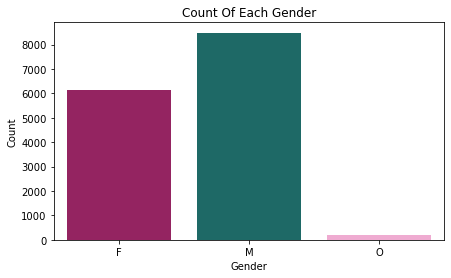

In [18]:
# visualize genders in count plot
colors = ['#A61263','#127571','#FAA0D2']

fig, ax = plt.subplots(figsize=(7,4))

sns.countplot(data=profile, x='gender', palette=sns.color_palette(colors))
plt.title('Count Of Each Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

__Overall, we have more male than female, gender O only takes 1.4% of whole population in the dataset.__ 

In [19]:
# Create bucket for age
interval_range = pd.interval_range(start=10, freq=10, end=110)
profile['age_group'] = pd.cut(profile['age'], bins=interval_range)
profile.head(3)

,gender,age,id,became_member_on,income,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,"(50, 60]"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,"(70, 80]"
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,"(60, 70]"


In [20]:
# check how many in each bucket
profile.age_group.value_counts(sort=False)

(10, 20]       340
(20, 30]      1365
(30, 40]      1597
(40, 50]      2391
(50, 60]      3590
(60, 70]      2910
(70, 80]      1646
(80, 90]       767
(90, 100]      214
(100, 110]       5
Name: age_group, dtype: int64

In [21]:
# Create bucket for income
interval_range = pd.interval_range(start=30000, freq=10000, end=120000)
profile['income_level'] = pd.cut(profile['income'], bins=interval_range)
profile.head(3)

,gender,age,id,became_member_on,income,age_group,income_level
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,"(50, 60]","(110000, 120000]"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,"(70, 80]","(90000, 100000]"
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,"(60, 70]","(60000, 70000]"


In [22]:
# check how many in each bucket
profile.income_level.value_counts(sort=False)

(30000, 40000]      2047
(40000, 50000]      1899
(50000, 60000]      2659
(60000, 70000]      2347
(70000, 80000]      2220
(80000, 90000]      1371
(90000, 100000]     1188
(100000, 110000]     546
(110000, 120000]     460
Name: income_level, dtype: int64

In [23]:
# convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
print('Earliest membership date: {}, lastest memebership date: {}'.
      format(profile.became_member_on.min(),profile.became_member_on.max()))

Earliest membership date: 2013-07-29 00:00:00, lastest memebership date: 2018-07-26 00:00:00


In [24]:
# creat `year` column by extract year from `became_member_on
profile['year'] = profile['became_member_on'].dt.year

# create a column 'days_being_member' based on 2018-7-26 as analyse date 
reference_day = datetime.datetime(2018, 7, 26)
profile['days_being_member'] =  (reference_day - profile['became_member_on']).dt.days

# drop original column `became_member_on`
profile = profile.drop('became_member_on', axis=1)

In [25]:
# check how many in each year
profile.year.value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: year, dtype: int64

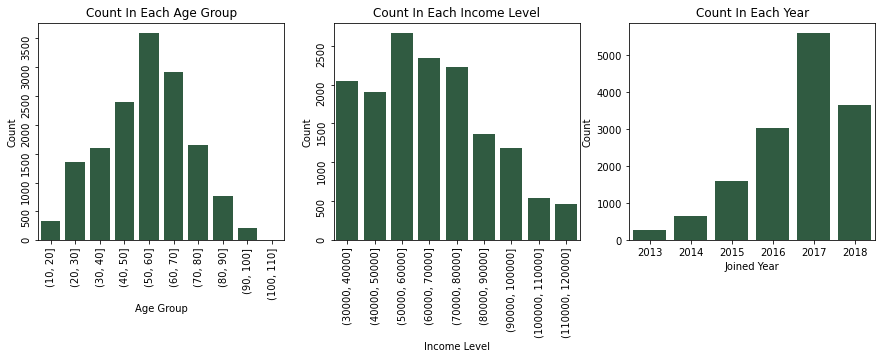

In [26]:
# Visualize `age`, `income` and `membership`

fig, ax = plt.subplots(ncols=3, figsize=(15,4))
color = '#29623F'

sns.countplot(ax=ax[0], data=profile, x='age_group', color=color)
ax[0].set_title('Count In Each Age Group')
ax[0].set_xlabel('Age Group')
ax[0].set_ylabel('Count')
ax[0].tick_params(labelrotation=90);

sns.countplot(ax=ax[1], data=profile, x='income_level', color=color)
ax[1].set_title('Count In Each Income Level')
ax[1].set_xlabel('Income Level')
ax[1].set_ylabel('Count')
ax[1].tick_params(labelrotation=90);

sns.countplot(ax=ax[2], data=profile, x='year', color=color)
ax[2].set_title('Count In Each Year')
ax[2].set_xlabel('Joined Year')
ax[2].set_ylabel('Count')
ax[2].set_ylabel('Count');

__From above observation, we can see majority age groups are between 40 to 70, and majority incomes are between 50k to 80k, and most of our users' membership is about one year old.__ 

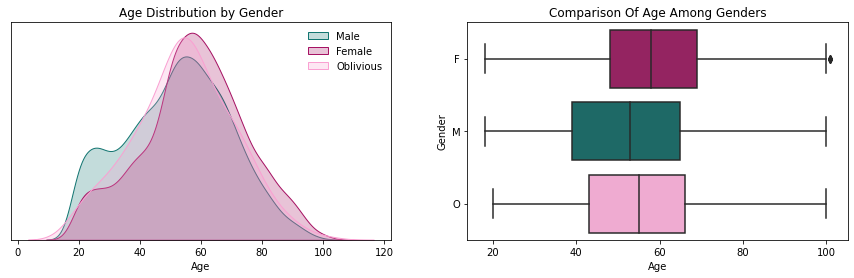

In [27]:
# Visualize the age by gender

fig, ax = plt.subplots(ncols=2, figsize=(15,4))

sns.distplot(ax=ax[0],x=profile[profile['gender']=='M']['age'],hist=False,color='#127571', kde_kws={'shade': True})
sns.distplot(ax=ax[0],x=profile[profile['gender']=='F']['age'],hist=False,color='#A61263', kde_kws={'shade': True})
sns.distplot(ax=ax[0],x=profile[profile['gender']=='O']['age'],hist=False,color='#FAA0D2', kde_kws={'shade': True})
ax[0].set_title('Age Distribution by Gender')
ax[0].set_xlabel('Age')
ax[0].get_yaxis().set_visible(False)
ax[0].legend(['Male','Female','Oblivious'],frameon=False)

sns.boxplot(ax=ax[1], data=profile, y='gender', x='age', palette=sns.color_palette(colors))
ax[1].set_title('Comparison Of Age Among Genders')
ax[1].set_ylabel('Gender')
ax[1].set_xlabel('Age');

In [28]:
print('Gender Male has average age {} and 50% of men over age {}'.format(profile[profile['gender']=='M']['age'].mean(),
                                                                        profile[profile['gender']=='M']['age'].median()))

Gender Male has average age 52.11669024045262 and 50% of men over age 53.0


In [29]:
print('Gender Female has average age {} and 50% of women over age {}'.format(profile[profile['gender']=='F']['age'].mean(),
                                                                        profile[profile['gender']=='F']['age'].median()))

Gender Female has average age 57.54495023658019 and 50% of women over age 58.0


In [30]:
print('Gender Oblivious has average age {} and 50% of them over age {}'.format(profile[profile['gender']=='O']['age'].mean(),
                                                                        profile[profile['gender']=='O']['age'].median()))

Gender Oblivious has average age 54.40094339622642 and 50% of them over age 55.0


__From above observation, we can see in our dataset, female is older than male in average. And every gender age data is slightly left skewed.__

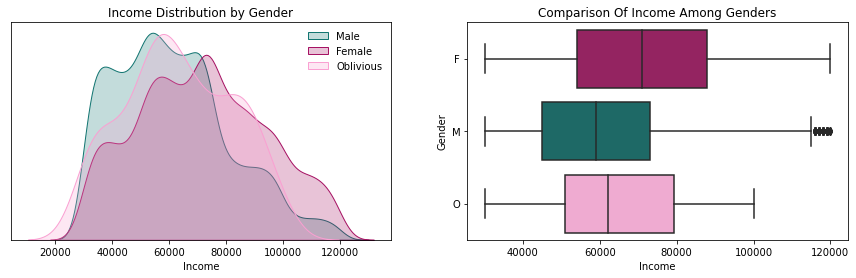

In [31]:
# Visualize the income by gender

fig, ax = plt.subplots(ncols=2, figsize=(15,4))

sns.distplot(ax=ax[0], x=profile[profile['gender']=='M']['income'],hist=False,color='#127571', kde_kws={'shade': True})
sns.distplot(ax=ax[0], x=profile[profile['gender']=='F']['income'],hist=False,color='#A61263', kde_kws={'shade': True})
sns.distplot(ax=ax[0], x=profile[profile['gender']=='O']['income'],hist=False,color='#FAA0D2', kde_kws={'shade': True})
ax[0].set_title('Income Distribution by Gender')
ax[0].set_xlabel('Income')
ax[0].get_yaxis().set_visible(False)
ax[0].legend(['Male','Female','Oblivious'],frameon=False)

sns.boxplot(ax=ax[1], data=profile, y='gender', x='income',palette=sns.color_palette(colors))
ax[1].set_title('Comparison Of Income Among Genders')
ax[1].set_ylabel('Gender')
ax[1].set_xlabel('Income');


In [32]:
print('Gender Male has average income {} and 50% of men earn more than {}'.format(profile[profile['gender']=='M']['income'].mean(),
                                                                        profile[profile['gender']=='M']['income'].median()))

Gender Male has average income 61194.60160301744 and 50% of men earn more than 59000.0


In [33]:
print('Gender Female has average income {} and 50% of women earn more than {}'.format(profile[profile['gender']=='F']['income'].mean(),
                                                                        profile[profile['gender']=='F']['income'].median()))

Gender Female has average income 71306.41213901126 and 50% of women earn more than 71000.0


In [34]:
print('Gender Oblivious has average income {} and 50% of them earn more than {}'.format(profile[profile['gender']=='O']['income'].mean(),
                                                                        profile[profile['gender']=='O']['income'].median()))

Gender Oblivious has average income 63287.735849056604 and 50% of them earn more than 62000.0


__From above observation, we can see in our dataset, female is earn more than male in average, gender man has outliers. And every gender income data is slightly right skewed.__

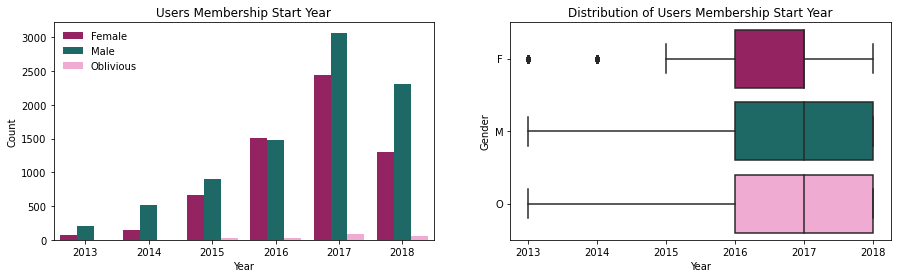

In [35]:
# Visualize the membership by gender
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

sns.countplot(ax=ax[0],data=profile, x='year', hue='gender',palette=sns.color_palette(colors))
ax[0].set_title('Users Membership Start Year')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Year')
ax[0].legend(['Female','Male','Oblivious'],frameon=False)

sns.boxplot(ax=ax[1], data=profile, x='year', y='gender', palette=sns.color_palette(colors))
ax[1].set_title('Distribution of Users Membership Start Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Gender');


__From above observation, we can see in our dataset, most users has membership less two years old (if we take 2018/07/26 as analysis date). 50% of user became member between 2016 to 2017.__

### File 3: transcript

In [36]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [37]:
# check the table shape
print('Transcript contains {} rows and {} columns'.format(transcript.shape[0], transcript.shape[1]))

Transcript contains 306534 rows and 4 columns


In [38]:
# check null value
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

__Luckily we do not have null value__

In [39]:
# check how many customers in the table
print('There are total {} customers in the transcript table.'.format(transcript.person.nunique()))

There are total 17000 customers in the transcript table.


__Same number of customers as in the `profile` table__

In [40]:
# check how long the experiment lasted
print('The experiment start from {}hour to {}hour.'.format(transcript.time.min(),transcript.time.max())) 

The experiment start from 0hour to 714hour.


In [41]:
714/24

29.75

__As mentioned in the introduction, the expriment ran 1 month, which matchs what we see in the dataset, 714/24 = 30days__

In [42]:
# check how many records for each type of event
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

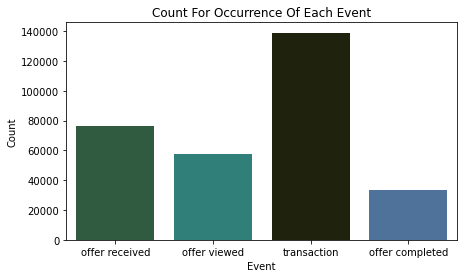

In [43]:
# visualize it ,'#67a9cf','#3690c0','#02818a','#016c59','#014636'
fig, ax = plt.subplots(figsize=(7,4))
colors2 = ['#29623F','#238C83','#212608','#4172A6']


sns.countplot(data=transcript, x='event', palette=sns.color_palette(colors2))
plt.title('Count For Occurrence Of Each Event')
plt.xlabel('Event')
plt.ylabel('Count');

In [44]:
# randomly check a customer's transcript record
transcript[transcript.person == '2cb4f97358b841b9a9773a7aa05a9d77']

,person,event,value,time
12647,2cb4f97358b841b9a9773a7aa05a9d77,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
29495,2cb4f97358b841b9a9773a7aa05a9d77,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},42
47580,2cb4f97358b841b9a9773a7aa05a9d77,transaction,{'amount': 2.93},126
100253,2cb4f97358b841b9a9773a7aa05a9d77,transaction,{'amount': 3.93},270
101459,2cb4f97358b841b9a9773a7aa05a9d77,transaction,{'amount': 2.24},276
135223,2cb4f97358b841b9a9773a7aa05a9d77,transaction,{'amount': 4.72},354
147214,2cb4f97358b841b9a9773a7aa05a9d77,transaction,{'amount': 3.27},390
163371,2cb4f97358b841b9a9773a7aa05a9d77,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
174353,2cb4f97358b841b9a9773a7aa05a9d77,transaction,{'amount': 6.46},420
174354,2cb4f97358b841b9a9773a7aa05a9d77,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,420


In [45]:
# randomly check another customer's transcript record
transcript[transcript.person == "aa4862eba776480b8bb9c68455b8c2e1"]

,person,event,value,time
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
20284,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},18
53183,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168
65845,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},168
83400,aa4862eba776480b8bb9c68455b8c2e1,transaction,{'amount': 12.33},210
83401,aa4862eba776480b8bb9c68455b8c2e1,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,210
110836,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336
123541,aa4862eba776480b8bb9c68455b8c2e1,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336
150604,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408
174355,aa4862eba776480b8bb9c68455b8c2e1,transaction,{'amount': 15.95},426


__From above observation on two random customers' transcript data, we can see:__

* Column `value` is written as a dictionary with key and value, which contains `offer id` and `transaction account`. 
* The event process should be `offer received` => `offer viewed` => `transaction` =>`offer completed`. However there are some orders `offer completed` without `offer viewed`, we can regard those completed orders made without influence by the offer because the customer never viewed the offer. 

__we need to do:__

* Unflat column `value` in order to join with the table `portfolio` to get detail about each offer.
* Check and distinguish each order if it's made with offer influence or not.

## Clean and Prepare the Data

__As we just mentioned above, we will:__

1. Flatten volume `value` in order to get transaction value and offer_id into seperate columns
2. Merge table `transcript` and table `profile`
3. Method to check and distinguish order if it's made with offer influence (with offer_viewed) or not:
  * Split table into two, one is with transaction, other with the rest events.
  * Create a function to check:
     
       1. If a `offer_viewd` was valid by checking if the `offer_viewed` within the offer validity period.
     
       2. If a `offer_completed` was influenced by the offer or not by checking if the `offer_completed` within the offer validity period and if there is a relevant `offer_viewed` before the `offer_completed`.  
     
     
 4. The final table for statistical analysis is like each row with one `offer_received`, follow by `offer_reviewed`, then `offer_completed` with `label` showing if this offer influenced_index(will explain more when taking this steps later) 


### 1. Flatten dictionary column `value`

In [46]:
rows = []
df = transcript["value"] 
for row, person, event, time in zip(df, transcript["person"],transcript["event"], transcript["time"]):
    row["person"] = person
    row["event"] = event
    row["time"] = time
    rows.append(row)

transcript = pd.DataFrame(rows)

In [47]:
# take a look at the new transcript table
transcript.head(3)

,offer id,person,event,time,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,NaN


In [48]:
# detect two columns with offer id 
transcript[transcript.offer_id.notnull()].head(3)

,offer id,person,event,time,amount,offer_id,reward
12658,NaN,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,NaN,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,NaN,629fc02d56414d91bca360decdfa9288,offer completed,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0


*Recall that we have `offer id` in original `value` column for two kinds event, `offer received` and `offer completed`, that's why we got two columns now, one is `offer id` for `offer received` and one is `offer_id` for `offer completed`. We can use np.where to combine value in those two columns*

In [49]:
# combine that two column 'offer_id' and 'offer id' into one
transcript['offer_id'] = np.where(transcript['offer_id'].isnull(), transcript['offer id'], transcript['offer_id'])
transcript.drop('offer id', axis=1, inplace=True)

In [50]:
# check null value
transcript.isnull().sum()

person           0
event            0
time             0
amount      167581
offer_id    138953
reward      272955
dtype: int64

In [51]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

*From above observation, we can see: total 138953 transactions and all without offer_id, but only connect to person_id. Since this project does not target to analyse the amount, so we will remove `transcript`.

### 2. Remove `transaction`  and then merge with `portfolio`

In [52]:
offers =transcript.loc[transcript["event"] != 'transaction']
offers = offers.reset_index(drop=True)
offers.drop('amount', axis=1, inplace=True)

In [53]:
offers.head(3)

,person,event,time,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN


In [54]:
# meger offers with portfolio
offers = pd.merge(offers, portfolio, how="inner", left_on='offer_id', right_on='id', 
                  suffixes=("_received", "_target"))

In [55]:
offers.shape

(167581, 12)

In [56]:
offers.head(3)

,person,event,time,offer_id,reward_received,reward_target,channels,difficulty,duration,offer_type,id,offer_name
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo7+5
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo7+5
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo7+5


In [57]:
offers = offers.drop(['reward_received', 'id'], axis=1)

### 3. Distinguish the offer influence index level and reshape the table

First we are going to create a function for that

In [58]:
def get_time_for_last_step(lis, start, end):
    
    '''
    This function is to find a number in the list within a period (start, end),
    If there is match, will return the first match value.
    If there is no match at all, will return a customs number.
    
    lis: a list in decending order in order to catch the closest one in time
    start: start number
    end: end number
    '''
    
    for x in lis:
        for y in range(start, end+1):
            if x==y:
                return x
    return 800                

In [59]:
def sign_order_id(df):
    
    '''
    This function to check each offer, and sign a new order_id and meantime determine influence_index.
    
    If event = offer_received: 
                      order_id = offer_id + person + time, influence_index=0
    If event = offer_viewed, check if event within offer validity period, if in, then sign:
                      order_id = offer_id + person + corresponding offer_recieve time, influence_index=1
                      if not:
                      order_id = offer_id + person + 800, influence_index=0
    If event = offer_completed, check if event within offer validity period, if in, then check:
                      if there is offer_viewed between received and completed, 
                             if yes
                             order_id = offer_id + person + corresponding offer_recieve time, influence_index=1
                             if not:
                             order_id = offer_id + person + corresponding offer_recieve time, influence_index=0
                      if offer_completed not within offer validity period:
                             order_id = offer_id + person + 800, influence_index=0 
    '''

    order_id = []
    influence_index = []

    for i in range(len(df)):
    
        event = df.loc[i, 'event']
    
        if event == 'offer received':
            given_id = df.loc[i, 'offer_id']+df.loc[i, 'person']+"-"+str(df.loc[i, 'time'])
            order_id.append(given_id)
            influence_index.append(0)
        
        if event == 'offer viewed':
            offer = df.loc[i, 'offer_id']
            validity = df.loc[i, 'duration']*24
            end = df.loc[i, 'time']
            start = int(end-validity)
            lis = df[(df['event'] == 'offer received') & (df['offer_id']== offer)].time.to_list()
            lis = sorted(lis, reverse=True)
        
            time = get_time_for_last_step(lis, start, end)
        
            given_id = df.loc[i, 'offer_id']+df.loc[i, 'person']+"-"+str(time)
            order_id.append(given_id)
            
            if time != 800:
                influence_index.append(1)
            else:
                influence_index.append(0)                   
        
        if event == 'offer completed':
            offer = df.loc[i, 'offer_id']
            validity = df.loc[i, 'duration']*24
            end = df.loc[i, 'time']
            start = int(end-validity)
            lis = df[(df['event'] == 'offer received') & (df['offer_id']== offer)].time.to_list()
            lis = sorted(lis, reverse=True)
        
            time = get_time_for_last_step(lis, start, end)
            
            given_id = df.loc[i, 'offer_id']+df.loc[i, 'person']+"-"+str(time)
            order_id.append(given_id)
        
            if time != 800:
                lis = df[(df['event'] == 'offer viewed') & (df['offer_id']== offer)].time.to_list()
                lis = sorted(lis, reverse=True)
            
                time1 = get_time_for_last_step(lis, time, end)
            
                if time1 != 800:
                    influence_index.append(1)
                    
                else:
                    influence_index.append(0)
                 
            else:
                influence_index.append(0)
    
                
    df['order_id'] = order_id
    df['influence_index'] = influence_index
    
    return df
        

__To improve function efficiency, we split data based on each user, then use the function check each offer's influence_index, after done for each user table, then concat them together, see following step:__

In [60]:
offer_list = []
person_list = offers.person.unique()

for person in person_list:
    person_df = offers[offers.person == person]
    person_df = person_df.reset_index(drop=True)
    person_df = sign_order_id(person_df)
    offer_list.append(person_df)    

offers = pd.concat(offer_list)

In [61]:
# take a look the table
offers.head(3)

,person,event,time,offer_id,reward_target,channels,difficulty,duration,offer_type,offer_name,order_id,influence_index
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,bogo7+5,9b98b8c7a33c4b65b9aebfe6a799e6d978afa995795e4d...,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,bogo7+5,9b98b8c7a33c4b65b9aebfe6a799e6d978afa995795e4d...,1
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,bogo7+5,9b98b8c7a33c4b65b9aebfe6a799e6d978afa995795e4d...,1


In [62]:
# check how many offer completed but without offer viewed before
offers[(offers.influence_index == 0) & (offers.event == 'offer completed')].event.count()

10045

In [63]:
# check how many offer completed with offer viewed before
offers[(offers.influence_index == 1) & (offers.event == 'offer completed')].event.count()

23534

In [64]:
# check how many offer viewed over offer valid period or offer completed without offer received
offers['signed_time'] = offers['order_id'].str[-3:]
offers[offers['signed_time']=='800'].event.value_counts()

offer viewed    1158
Name: event, dtype: int64

__We can see there is no offer completed without offer received, but there are 1158 offer viewed after offer validity period. We will remove those invalid offer viewed from the dataset__

In [65]:
# remove those offer_viewed total 1158 which not in offer validity period
offers = offers[offers['signed_time'] !='800']
# drop the column 'signed_number' which we do not need anymore
offers = offers.drop('signed_time', axis=1)

In [66]:
# split table into three based on event
offer_received = offers[offers['event'] == 'offer received']

offer_viewed = offers[offers['event'] == 'offer viewed']
offer_viewed = offer_viewed[['event','time','order_id','influence_index']]

offer_completed = offers[offers['event'] == 'offer completed']
offer_completed = offer_completed[['event','time','order_id', 'influence_index']]


__Since we are going to join those three table together based on the `order_id`, we need to know if there is duplicated offer_id in each table and investage if there is__ 

In [67]:
# check if there is duplicated value in offer_viewed table
offer_viewed.duplicated('order_id').sum()

0

In [68]:
# how many offer_viewed in the offer_viewed table
len(offer_viewed)

56567

__56567 is the right number, because we originally have 57725 viewed, and we just removed 1158 unvalid review__ 

In [69]:
# check if there is duplicated value in offer_completed table
offer_completed.duplicated('order_id').sum()

478

__There are 478 dubplicated value in offer_completed table when we sign order_id,we must check it first and decide if we should keep it or remove it.__ 

In [70]:
# take a look what the duplicates look like
pd.set_option('display.max_colwidth', None)
offer_completed[offer_completed.duplicated('order_id', keep=False)].groupby('order_id').head()

,event,time,order_id,influence_index
7,offer completed,498,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-408,1
8,offer completed,552,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-408,1
5,offer completed,636,fafdcd668e3743c1bb461111dcafc2a42cad48dcddc44f9dac43c2d9b476535b-576,1
6,offer completed,672,fafdcd668e3743c1bb461111dcafc2a42cad48dcddc44f9dac43c2d9b476535b-576,1
9,offer completed,504,2906b810c7d4411798c6938adc9daaa5ebb683a739d443e39f8b913b82163d02-504,0
...,...,...,...,...
5,offer completed,648,2298d6c36e964ae4a3e7e9706d1fb8c2c9eed1f79316414183383096b7a95347-576,1
3,offer completed,408,ae264e3637204a6fb9bb56bc8210ddfd7286558fde4642518fcd9a35e377cb56-408,0
4,offer completed,408,ae264e3637204a6fb9bb56bc8210ddfd7286558fde4642518fcd9a35e377cb56-408,0
3,offer completed,576,ae264e3637204a6fb9bb56bc8210ddfd5bde1a82680d41aba0eb33627e188eaf-576,0


In [71]:
# Investigate what really happened in single customer and offer
offers[(offers.offer_id=='0b1e1539f2cc45b7b9fa7c272da2e1d7') & 
       (offers.person=='072731be403a472883bed6c38a8e7aa8')]

,person,event,time,offer_id,reward_target,channels,difficulty,duration,offer_type,offer_name,order_id,influence_index
0,072731be403a472883bed6c38a8e7aa8,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,discount10+20,0b1e1539f2cc45b7b9fa7c272da2e1d7072731be403a472883bed6c38a8e7aa8-336,0
1,072731be403a472883bed6c38a8e7aa8,offer viewed,354,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,discount10+20,0b1e1539f2cc45b7b9fa7c272da2e1d7072731be403a472883bed6c38a8e7aa8-336,1
2,072731be403a472883bed6c38a8e7aa8,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,discount10+20,0b1e1539f2cc45b7b9fa7c272da2e1d7072731be403a472883bed6c38a8e7aa8-408,0
3,072731be403a472883bed6c38a8e7aa8,offer completed,492,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,discount10+20,0b1e1539f2cc45b7b9fa7c272da2e1d7072731be403a472883bed6c38a8e7aa8-408,0
4,072731be403a472883bed6c38a8e7aa8,offer viewed,516,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,discount10+20,0b1e1539f2cc45b7b9fa7c272da2e1d7072731be403a472883bed6c38a8e7aa8-408,1
5,072731be403a472883bed6c38a8e7aa8,offer completed,564,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,discount10+20,0b1e1539f2cc45b7b9fa7c272da2e1d7072731be403a472883bed6c38a8e7aa8-408,1


__From above investigation, we can see that our function correctly distinct the completion if it's made after view or before view. The duplicate `order id` because the user completed offer two times during a valid offer period, one was made without view, and one made after view, that's why those two completions related to same offer reveived time.__ 

In [72]:
# let's check another one if it's in same situation
offers[(offers.offer_id=='fafdcd668e3743c1bb461111dcafc2a4') & 
       (offers.person=='9a9a6f44405f49fdb0c3fa45109767d5')]

,person,event,time,offer_id,reward_target,channels,difficulty,duration,offer_type,offer_name,order_id,influence_index
3,9a9a6f44405f49fdb0c3fa45109767d5,offer received,336,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,discount10+10,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-336,0
4,9a9a6f44405f49fdb0c3fa45109767d5,offer viewed,366,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,discount10+10,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-336,1
5,9a9a6f44405f49fdb0c3fa45109767d5,offer received,408,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,discount10+10,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-408,0
6,9a9a6f44405f49fdb0c3fa45109767d5,offer viewed,432,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,discount10+10,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-408,1
7,9a9a6f44405f49fdb0c3fa45109767d5,offer completed,498,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,discount10+10,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-408,1
8,9a9a6f44405f49fdb0c3fa45109767d5,offer completed,552,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,discount10+10,fafdcd668e3743c1bb461111dcafc2a49a9a6f44405f49fdb0c3fa45109767d5-408,1


__From this one above, double confirmed that our function correctly distinct the completion if it's made after view or before view. And The duplicate `order id` in `offer_completed` table is because the user completed offer two times during a valid offer period, that's why those two completions related to same offer reveived time.__ 

__After the investigation, we believe all duplicate `order id` in `offer_completed` caused by more than one time completion for same offer during the offer valid period. Since we are planning to make the final table with each offer with completion status in one row, so for the second time completion, we do need to duplicate the offer_received in order to make the second row for second completion. Therefore, we will keep the duplicate offer_id.__

__Next step we are going to merge those three tables based on `order_id`, since we have 478 duplicate `order_id` in `offer_completed` table. This will make:__ 
1. number of offer_received will increase by 478.
2. number of offer_viewed will increase by 478.

__*note: above number will be further changed by late on `labeling`__.

In [73]:
# merge those three table based on order_id
offers_reshaped = pd.merge(offer_received, offer_viewed, how="left", on='order_id', suffixes=("_received", "_viewed"))
offers_reshaped = pd.merge(offers_reshaped, offer_completed, how="left", on='order_id')

In [74]:
offers_reshaped.head(3)

,person,event_received,time_received,offer_id,reward_target,channels,difficulty,duration,offer_type,offer_name,order_id,influence_index_received,event_viewed,time_viewed,influence_index_viewed,event,time,influence_index
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,bogo7+5,9b98b8c7a33c4b65b9aebfe6a799e6d978afa995795e4d85b5d9ceeca43f5fef-0,0,offer viewed,6.0,1.0,offer completed,132.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,f19421c1d4aa40978ebb69ca19b0e20d78afa995795e4d85b5d9ceeca43f5fef-504,0,offer viewed,582.0,1.0,offer completed,510.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,bogo7+10,ae264e3637204a6fb9bb56bc8210ddfd78afa995795e4d85b5d9ceeca43f5fef-408,0,offer viewed,408.0,1.0,offer completed,510.0,1.0


In [75]:
# take look at the `offer_completed` with `0` influence_index
offers_reshaped[offers_reshaped.influence_index==0].head(3)

,person,event_received,time_received,offer_id,reward_target,channels,difficulty,duration,offer_type,offer_name,order_id,influence_index_received,event_viewed,time_viewed,influence_index_viewed,event,time,influence_index
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,f19421c1d4aa40978ebb69ca19b0e20d78afa995795e4d85b5d9ceeca43f5fef-504,0,offer viewed,582.0,1.0,offer completed,510.0,0.0
10,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,bogo7+5,9b98b8c7a33c4b65b9aebfe6a799e6d9f082d80f0aac47a99173ba8ef8fc1909-0,0,offer viewed,48.0,1.0,offer completed,12.0,0.0
29,a3b9b4bf115e4564933ea2e4bc936843,offer received,576,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,discount7+10,2906b810c7d4411798c6938adc9daaa5a3b9b4bf115e4564933ea2e4bc936843-576,0,NaN,NaN,NaN,offer completed,624.0,0.0


In [76]:
# take look at the `offer_completed` with `1` influence_index
offers_reshaped[offers_reshaped.influence_index==1].head(3)

,person,event_received,time_received,offer_id,reward_target,channels,difficulty,duration,offer_type,offer_name,order_id,influence_index_received,event_viewed,time_viewed,influence_index_viewed,event,time,influence_index
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,bogo7+5,9b98b8c7a33c4b65b9aebfe6a799e6d978afa995795e4d85b5d9ceeca43f5fef-0,0,offer viewed,6.0,1.0,offer completed,132.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,bogo7+10,ae264e3637204a6fb9bb56bc8210ddfd78afa995795e4d85b5d9ceeca43f5fef-408,0,offer viewed,408.0,1.0,offer completed,510.0,1.0
6,ebe7ef46ea6f4963a7dd49f501b26779,offer received,408,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,discount7+10,2906b810c7d4411798c6938adc9daaa5ebe7ef46ea6f4963a7dd49f501b26779-408,0,offer viewed,420.0,1.0,offer completed,432.0,1.0


__From above observation, again we can see our function correctly distinguished if an offer completed after the offer open or before the offer open.__

__Next step, we are going to label each offer with:__

* `0` for `offer_recieved` but no `offer_viewed`
* `1` for `offer_viewed` but no `offer_complete`
* `2` for `offer_viewed` and followed with `offer_completed`
* `-1` for `offer_completed` without `offer_viewed` before


In [77]:
# drop the no need columns
offers_reshaped = offers_reshaped.drop(['event_received', 'time_received', 'offer_id','order_id',
                                    'influence_index_received', 'event_viewed','time_viewed', 
                                    'event','time'], axis=1)    

In [78]:
offers_reshaped.head(3)

,person,reward_target,channels,difficulty,duration,offer_type,offer_name,influence_index_viewed,influence_index
0,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile]",5,7,bogo,bogo7+5,1.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,1.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,10,"[email, mobile, social]",10,7,bogo,bogo7+10,1.0,1.0


In [79]:
# fill the null value in column `influence_index` with `none` in order to difference exit value 1 and 0
offers_reshaped['influence_index_viewed']= offers_reshaped['influence_index_viewed'].fillna('none')
offers_reshaped['influence_index']= offers_reshaped['influence_index'].fillna('none')

In [80]:
# criteria for the lable
criteria = [
   (offers_reshaped.influence_index == 1),
   (offers_reshaped.influence_index == 0),
   (offers_reshaped.influence_index_viewed == 1) & (offers_reshaped.influence_index == 'none'), 
   (offers_reshaped.influence_index_viewed =='none') & (offers_reshaped.influence_index == 'none')
]
label = ['2','-1','1','0']

In [81]:
# label each row based on criteria
offers_reshaped['label'] = np.select(criteria, label)

In [82]:
# drop the columns which no need
offers_reshaped = offers_reshaped.drop(['influence_index_viewed','influence_index'], axis=1)

In [83]:
offers_reshaped.head(3)

,person,reward_target,channels,difficulty,duration,offer_type,offer_name,label
0,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile]",5,7,bogo,bogo7+5,2
1,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,-1
2,78afa995795e4d85b5d9ceeca43f5fef,10,"[email, mobile, social]",10,7,bogo,bogo7+10,2


In [84]:
offers_reshaped.label.value_counts(dropna=False)

1     29195
2     23534
0     13981
-1    10045
Name: label, dtype: int64

In [85]:
# merge table `offers_reshaped` and `profile`
offers_final = pd.merge(offers_reshaped, profile, how='inner', left_on='person', right_on='id')

In [86]:
offers_final.drop('id', axis=1, inplace=True)

In [87]:
offers_final.head(3)

,person,reward_target,channels,difficulty,duration,offer_type,offer_name,label,gender,age,income,age_group,income_level,year,days_being_member
0,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile]",5,7,bogo,bogo7+5,2,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443
1,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,-1,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443
2,78afa995795e4d85b5d9ceeca43f5fef,10,"[email, mobile, social]",10,7,bogo,bogo7+10,2,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443


In [88]:
offers_final.label.value_counts(dropna=False)

2     22576
1     22456
0     12045
-1     9868
Name: label, dtype: int64

In [89]:
len(offers_final)

66945

We can see the number of label decreased after merging table profile, because the profile table contains less people that in offers_reshaped table. So in cleaned final dataset, we have total:

* offer_received:                                       66945
* offer_viewed:                                         45032 (label1+ label2)
* offer_completed with influence:                       22576 (label2)
* offer_completed without influence:                     9867 (label-1)


## Statistical Analysis

In this session, we will:

=> Firstly inverstigate __which offer is the best offer?__ based on this one month experiment, the metrics we are going to use are:

* __View_rate__: Total viewed divided by total number of received
* __Influence_complete_rate__: total number of completion with viewed record in advance divided by total number of received
* __Uninfluence_complete_rate__: total number of completion without viewed record before divided by total number of received

We will also check how an offer's difficulty, duration or reward effect an offer's completion both influence or uninfluence.

=> Then we will dive deeper in to demographic groups, and investigate __which demographic groups will more likly complete an offer after seeing the offer?__ and __which demographic groups will more likly complete an offer without seeeing the offer?__ The critera we are going to use is:

* __offer_sensitive__: if influence_complete_rate >= uninfluence_complete_rate and influence_complete_rate > 50%
* __offer_insensitive__: if influence_complete_rate < uninfluence_complete_rate and uninfluence_complete_rate > 50%


In [90]:
# let's check each offer's performance
offer_result = offers_reshaped.groupby(['offer_type','offer_name', 'duration', 'difficulty', 'reward_target'])\
                            .label.agg(
                                       [('received', 'count'),
                                        ('viewed', lambda x: (x=='1').sum()+(x=='2').sum()),
                                        ('completed_influenced',lambda x: (x=='2').sum()),
                                        ('completed_no_influenced', lambda x: (x=='-1').sum())
                                       ]).reset_index()

In [91]:
offer_result

,offer_type,offer_name,duration,difficulty,reward_target,received,viewed,completed_influenced,completed_no_influenced
0,bogo,bogo5+10,5,10,10,7623,6800,2759,572
1,bogo,bogo5+5,5,5,5,7605,6629,3529,767
2,bogo,bogo7+10,7,10,10,7711,6093,2606,1082
3,bogo,bogo7+5,7,5,5,7728,3564,2124,2230
4,discount,discount10+10,10,10,2,7684,6891,4653,664
5,discount,discount10+20,10,20,5,7775,2454,1339,2081
6,discount,discount7+10,7,10,2,7694,3574,2134,1883
7,discount,discount7+7,7,7,3,7700,6777,4390,766
8,informational,informational3+0,3,0,0,7618,6149,0,0
9,informational,informational4+0,4,0,0,7617,3798,0,0


In [92]:
# add view_rate, influence_complete_rate and uninfluence_complete_rate
offer_result['view_rate'] = np.round(offer_result['viewed']/offer_result['received']*100, 2)
offer_result['influenced_complete_rate'] = np.round(offer_result['completed_influenced']/offer_result['received']*100, 2)
offer_result['unfluenced_complete_rate'] = np.round(offer_result['completed_no_influenced']/offer_result['received']*100, 2)

In [93]:
offer_result

,offer_type,offer_name,duration,difficulty,reward_target,received,viewed,completed_influenced,completed_no_influenced,view_rate,influenced_complete_rate,unfluenced_complete_rate
0,bogo,bogo5+10,5,10,10,7623,6800,2759,572,89.20,36.19,7.50
1,bogo,bogo5+5,5,5,5,7605,6629,3529,767,87.17,46.40,10.09
2,bogo,bogo7+10,7,10,10,7711,6093,2606,1082,79.02,33.80,14.03
3,bogo,bogo7+5,7,5,5,7728,3564,2124,2230,46.12,27.48,28.86
4,discount,discount10+10,10,10,2,7684,6891,4653,664,89.68,60.55,8.64
5,discount,discount10+20,10,20,5,7775,2454,1339,2081,31.56,17.22,26.77
6,discount,discount7+10,7,10,2,7694,3574,2134,1883,46.45,27.74,24.47
7,discount,discount7+7,7,7,3,7700,6777,4390,766,88.01,57.01,9.95
8,informational,informational3+0,3,0,0,7618,6149,0,0,80.72,0.00,0.00
9,informational,informational4+0,4,0,0,7617,3798,0,0,49.86,0.00,0.00


__From above offer_result table, we can see:__

All 10 types of offer has quiet balanced number of release times, between 7600 to 7700 times. Among those times:

* `Discount10+10` got highest view rate 89.68%, followed by `Bogo5+10` and `Discount7+7`
* `Discount10+10` got the highest influenced complete rate 60.55%, followed by `discount7+7`
* `Bogo7+5` go the highest uninfluence completed rate 28.86%, followed by `discount10+20`

In general, `Discount10+10` is the most popular offer.

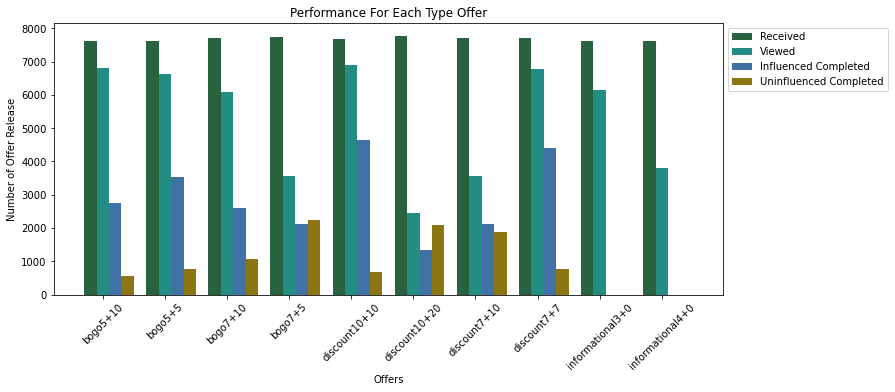

In [94]:
# Visualize the offer_result
fig, ax = plt.subplots(figsize=(12,5))

x_axis = np.arange(len(offer_result))
#colors2 = ['#29623F','#294B61','#61294B','#613E29']

plt.bar(x_axis -0.2, offer_result.received, 0.2, color='#29623F',label='Received', align='center')
plt.bar(x_axis, offer_result.viewed, 0.2, color='#238C83',label='Viewed',align='center')
plt.bar(x_axis +0.2, offer_result.completed_influenced, 0.2, color='#4172A6',label='Influenced Completed', align='center')
plt.bar(x_axis +0.4, offer_result.completed_no_influenced, 0.2, color='#8C7614',label='Uninfluenced Completed', align='center')

plt.xticks(x_axis, offer_result['offer_name'], rotation=45)
plt.xlabel("Offers")
plt.ylabel("Number of Offer Release")
plt.title("Performance For Each Type Offer")
plt.legend(bbox_to_anchor=(1, 1));

In [95]:
# check if an offer duration lead different result
duration = offer_result.groupby('duration').agg({'influenced_complete_rate':'mean', 'unfluenced_complete_rate':'mean'}).reset_index()
duration

,duration,influenced_complete_rate,unfluenced_complete_rate
0,3,0.0000,0.0000
1,4,0.0000,0.0000
2,5,41.2950,8.7950
3,7,36.5075,19.3275
4,10,38.8850,17.7050


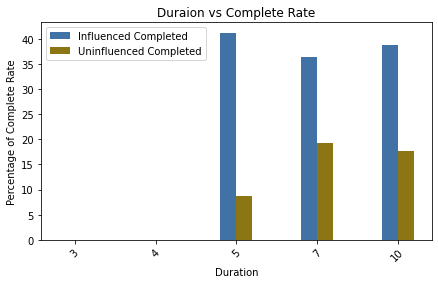

In [96]:
# Visualize the offer_result
fig, ax = plt.subplots(figsize=(7,4))

x_axis = np.arange(len(duration))
#colors2 = ['#29623F','#294B61','#61294B','#613E29']

plt.bar(x_axis -0.1, duration.influenced_complete_rate, 0.2, color='#4172A6',label='Influenced Completed', align='center')
plt.bar(x_axis +0.1, duration.unfluenced_complete_rate, 0.2, color='#8C7614',label='Uninfluenced Completed', align='center')

plt.xticks(x_axis, duration['duration'], rotation=45)
plt.xlabel("Duration")
plt.ylabel("Percentage of Complete Rate")
plt.title("Duraion vs Complete Rate")
plt.legend();

__Seems duration does not make much difference in compelte_rate, but the longer duration makes people who does not open the offer have more time to complete an offer, which actually not good from a business perspective.__

In [97]:
# check if an offer difficulty lead different result
difficulty = offer_result.groupby('difficulty').agg({'influenced_complete_rate':'mean', 'unfluenced_complete_rate':'mean'}).reset_index()
difficulty

,difficulty,influenced_complete_rate,unfluenced_complete_rate
0,0,0.00,0.000
1,5,36.94,19.475
2,7,57.01,9.950
3,10,39.57,13.660
4,20,17.22,26.770


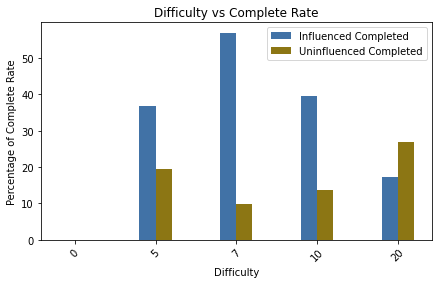

In [98]:
# Visualize the offer_result
fig, ax = plt.subplots(figsize=(7,4))

x_axis = np.arange(len(difficulty))
#colors2 = ['#29623F','#294B61','#61294B','#613E29']

plt.bar(x_axis -0.1, difficulty.influenced_complete_rate, 0.2, color='#4172A6',label='Influenced Completed', align='center')
plt.bar(x_axis +0.1, difficulty.unfluenced_complete_rate, 0.2, color='#8C7614',label='Uninfluenced Completed', align='center')

plt.xticks(x_axis, difficulty['difficulty'], rotation=45)
plt.xlabel("Difficulty")
plt.ylabel("Percentage of Complete Rate")
plt.title("Difficulty vs Complete Rate")
plt.legend(bbox_to_anchor=(1, 1));

__Seems high difficulty results lower influenced_complete_rate, but difficulty 7 seems more acceptable. However if we look at uninfluence_complete_rate, the number very much confirm what we assumed, people not open an offer so not influence what the offer is, they just buy whenever they want, from a business perspective, why do we send them an offer, they buy anyway.__

In [99]:
# check if an offer reward lead different result
reward = offer_result.groupby('reward_target').agg({'influenced_complete_rate':'mean', 'unfluenced_complete_rate':'mean'}).reset_index()
reward

,reward_target,influenced_complete_rate,unfluenced_complete_rate
0,0,0.000000,0.000000
1,2,44.145000,16.555000
2,3,57.010000,9.950000
3,5,30.366667,21.906667
4,10,34.995000,10.765000


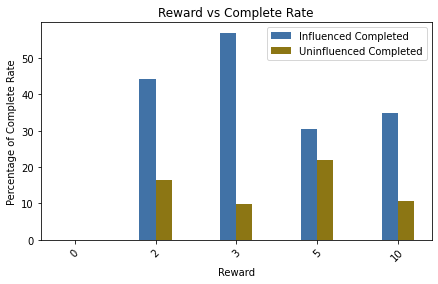

In [100]:
# Visualize the offer_result
fig, ax = plt.subplots(figsize=(7,4))

x_axis = np.arange(len(reward))
#colors2 = ['#29623F','#294B61','#61294B','#613E29']

plt.bar(x_axis -0.1, reward.influenced_complete_rate, 0.2, color='#4172A6',label='Influenced Completed', align='center')
plt.bar(x_axis +0.1, reward.unfluenced_complete_rate, 0.2, color='#8C7614',label='Uninfluenced Completed', align='center')

plt.xticks(x_axis, reward['reward_target'], rotation=45)
plt.xlabel("Reward")
plt.ylabel("Percentage of Complete Rate")
plt.title("Reward vs Complete Rate")
plt.legend(bbox_to_anchor=(1, 1));

__From above observation, it seems that people like get reward 2 or 3(probably also because low difficulty). For people who never open an offer do not care about reward amount.__

Next we are going to dive deeper into demografic group. 

Firstly we visualize the distribution of age, income, days_being_member in each gender between influent_completed and uninfluent_completed to see the difference.

Then we will group the users based on demographic features to see which groups are offer sensitive and which are not, how likely they react on different offers. 

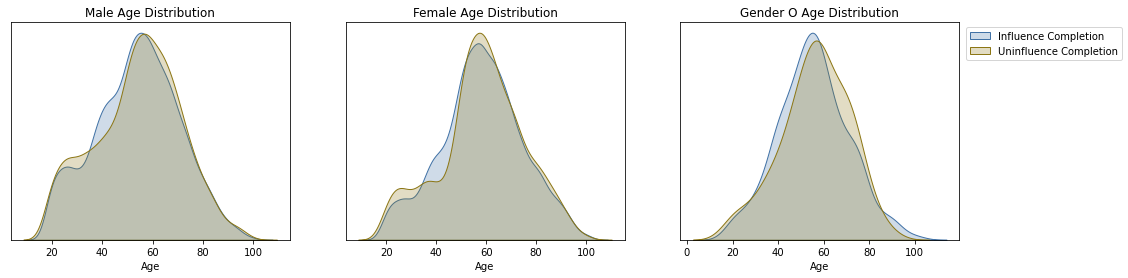

In [101]:
# Visualize the age distribution for influence completion and uninfluence completion for each gender

fig, ax = plt.subplots(ncols=3, figsize=(17,4))

sns.distplot(ax=ax[0],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='M')]['age'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[0],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='M')]['age'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[0].set_title('Male Age Distribution')
ax[0].set_xlabel('Age')
ax[0].get_yaxis().set_visible(False)

sns.distplot(ax=ax[1],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='F')]['age'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[1],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='F')]['age'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[1].set_title('Female Age Distribution')
ax[1].set_xlabel('Age')
ax[1].get_yaxis().set_visible(False)

sns.distplot(ax=ax[2],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='O')]['age'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[2],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='O')]['age'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[2].set_title('Gender O Age Distribution')
ax[2].set_xlabel('Age')
ax[2].get_yaxis().set_visible(False)
ax[2].legend(['Influence Completion','Uninfluence Completion'],bbox_to_anchor=(1.6, 1));

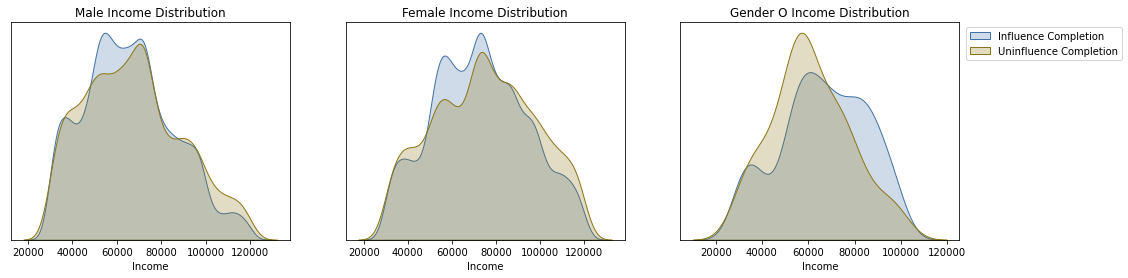

In [102]:
# Visualize the income distribution for influence completion and uninfluence completion for each gender

fig, ax = plt.subplots(ncols=3, figsize=(17,4))

sns.distplot(ax=ax[0],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='M')]['income'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[0],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='M')]['income'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[0].set_title('Male Income Distribution')
ax[0].set_xlabel('Income')
ax[0].get_yaxis().set_visible(False)

sns.distplot(ax=ax[1],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='F')]['income'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[1],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='F')]['income'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[1].set_title('Female Income Distribution')
ax[1].set_xlabel('Income')
ax[1].get_yaxis().set_visible(False)

sns.distplot(ax=ax[2],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='O')]['income'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[2],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='O')]['income'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[2].set_title('Gender O Income Distribution')
ax[2].set_xlabel('Income')
ax[2].get_yaxis().set_visible(False)
ax[2].legend(['Influence Completion','Uninfluence Completion'],bbox_to_anchor=(1.6, 1));

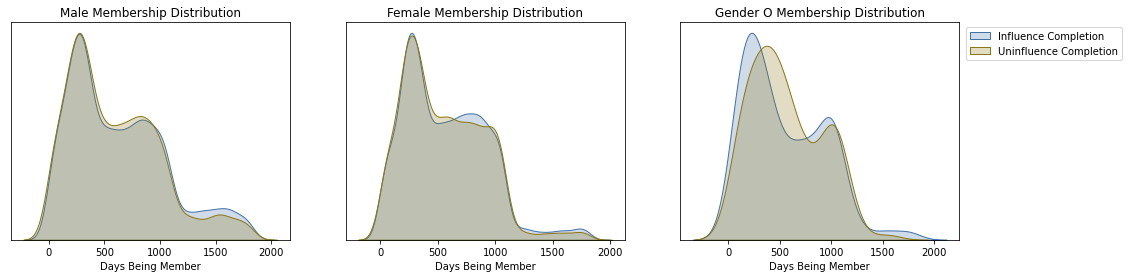

In [103]:
# Visualize the days_being_member distribution for influence completion and uninfluence completion for each gender

fig, ax = plt.subplots(ncols=3, figsize=(17,4))

sns.distplot(ax=ax[0],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='M')]['days_being_member'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[0],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='M')]['days_being_member'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[0].set_title('Male Membership Distribution')
ax[0].set_xlabel('Days Being Member')
ax[0].get_yaxis().set_visible(False)

sns.distplot(ax=ax[1],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='F')]['days_being_member'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[1],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='F')]['days_being_member'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[1].set_title('Female Membership Distribution')
ax[1].set_xlabel('Days Being Member')
ax[1].get_yaxis().set_visible(False)

sns.distplot(ax=ax[2],x=offers_final[(offers_final['label']=='2') & (offers_final['gender']=='O')]['days_being_member'],hist=False,color='#4172A6', kde_kws={'shade': True})
sns.distplot(ax=ax[2],x=offers_final[(offers_final['label']=='-1') & (offers_final['gender']=='O')]['days_being_member'],hist=False,color='#8C7614', kde_kws={'shade': True})

ax[2].set_title('Gender O Membership Distribution')
ax[2].set_xlabel('Days Being Member')
ax[2].get_yaxis().set_visible(False)
ax[2].legend(['Influence Completion','Uninfluence Completion'],bbox_to_anchor=(1.6, 1));

__Let's see how different demografical group reacted to different offer__


In [104]:
# group each demografical feature and calculate the number of received, viewed, completion
demo_group_result = offers_final.groupby(['gender','year','age_group','income_level','offer_name'])\
                            .label.agg(
                                       [('received', 'count'),
                                        ('viewed', lambda x: (x=='1').sum()+(x=='2').sum()),
                                        ('completed_influenced',lambda x: (x=='2').sum()),
                                        ('completed_no_influenced', lambda x: (x=='-1').sum())
                                       ]).reset_index()

In [105]:
# quick a look the result head
demo_group_result.head(3)

,gender,year,age_group,income_level,offer_name,received,viewed,completed_influenced,completed_no_influenced
0,F,2013,"(10, 20]","(30000, 40000]",bogo5+10,0,NaN,NaN,NaN
1,F,2013,"(10, 20]","(30000, 40000]",bogo5+5,0,NaN,NaN,NaN
2,F,2013,"(10, 20]","(30000, 40000]",bogo7+10,0,NaN,NaN,NaN


In [106]:
# check of there is group with null value
demo_group_result.isnull().sum()

gender                        0
year                          0
age_group                     0
income_level                  0
offer_name                    0
received                      0
viewed                     9225
completed_influenced       9225
completed_no_influenced    9225
dtype: int64

There are some groups did not receive any offer during this experiment

In [107]:
# drop the null value
demo_group_result.dropna(inplace=True)

In [108]:
# drop the rows if both complete_influence and complete_no_influence are zero
demo_group_result = demo_group_result[(demo_group_result['completed_influenced']!=0) & (demo_group_result['completed_no_influenced']!=0)]

In [109]:
# take a result head again
demo_group_result.head(3)

,gender,year,age_group,income_level,offer_name,received,viewed,completed_influenced,completed_no_influenced
207,F,2013,"(30, 40]","(50000, 60000]",discount7+7,2,1.0,1.0,1.0
281,F,2013,"(40, 50]","(40000, 50000]",bogo5+5,3,1.0,1.0,1.0
324,F,2013,"(40, 50]","(80000, 90000]",discount10+10,2,1.0,1.0,1.0


In [110]:
# add view_rate, influence_complete_rate and uninfluence_complete_rate
demo_group_result['view_rate'] = np.round(demo_group_result['viewed']/demo_group_result['received']*100, 2)
demo_group_result['influenced_complete_rate'] = np.round(demo_group_result['completed_influenced']/demo_group_result['received']*100, 2)
demo_group_result['unfluenced_complete_rate'] = np.round(demo_group_result['completed_no_influenced']/demo_group_result['received']*100, 2)

__Split the demographical group to `offer_sensitive` or `offer_insensitive` by following criteria:__
* offer_sensitive: influenced_complete_rate >= unfluenced_complete_rate & influenced_complete_rate > 50%
* offer_insensitive: influenced_complete_rate < unfluenced_complete_rate & uninfluenced_complete_rate > 50%

In [111]:
offer_sensitive = demo_group_result[(demo_group_result['influenced_complete_rate'] >= demo_group_result['unfluenced_complete_rate']) & 
                                   (demo_group_result['influenced_complete_rate'] > 50)]

offer_insensitive = demo_group_result[(demo_group_result['influenced_complete_rate'] < demo_group_result['unfluenced_complete_rate']) &
                                     (demo_group_result['unfluenced_complete_rate'] > 50)]

In [112]:
# sort value base on incluence_complete_rate to see the offer_insensitive groups we have
offer_sensitive = offer_sensitive.sort_values(['influenced_complete_rate'], ascending=False)

# sort value base on incluence_complete_rate to see the offer_insensitive groups we have
offer_insensitive = offer_insensitive.sort_values(['unfluenced_complete_rate'], ascending=False)

In [113]:
print('There are {} groups which more likely be influenced by an offer.'.format(len(offer_sensitive)))

There are 975 groups which more likely be influenced by an offer.


In [114]:
print('There are {} groups which more likely they buy anyway no matter if there is an offer or not.'.format(len(offer_insensitive)))

There are 179 groups which more likely they buy anyway no matter if there is an offer or not.


In [115]:
# let's take a look at who they are in the top 10 of offer_sensitive groups
offer_sensitive.head(10)

,gender,year,age_group,income_level,offer_name,received,viewed,completed_influenced,completed_no_influenced,view_rate,influenced_complete_rate,unfluenced_complete_rate
3217,F,2016,"(60, 70]","(90000, 100000]",discount7+7,24,23.0,23.0,1.0,95.83,95.83,4.17
3097,F,2016,"(50, 60]","(60000, 70000]",discount7+7,19,18.0,18.0,1.0,94.74,94.74,5.26
8507,M,2016,"(50, 60]","(70000, 80000]",discount7+7,35,34.0,33.0,1.0,97.14,94.29,2.86
8407,M,2016,"(40, 50]","(60000, 70000]",discount7+7,16,15.0,15.0,1.0,93.75,93.75,6.25
2214,F,2015,"(50, 60]","(80000, 90000]",discount10+10,15,14.0,14.0,1.0,93.33,93.33,6.67
7494,M,2015,"(40, 50]","(50000, 60000]",discount10+10,15,14.0,14.0,1.0,93.33,93.33,6.67
7414,M,2015,"(30, 40]","(60000, 70000]",discount10+10,15,14.0,14.0,1.0,93.33,93.33,6.67
3287,F,2016,"(70, 80]","(70000, 80000]",discount7+7,15,14.0,14.0,1.0,93.33,93.33,6.67
3017,F,2016,"(40, 50]","(70000, 80000]",discount7+7,14,13.0,13.0,1.0,92.86,92.86,7.14
8567,M,2016,"(60, 70]","(40000, 50000]",discount7+7,14,13.0,13.0,1.0,92.86,92.86,7.14


In [116]:
# let's take a look at who they are in the top 10 in offer_insensitive groups
offer_insensitive.head(10)

,gender,year,age_group,income_level,offer_name,received,viewed,completed_influenced,completed_no_influenced,view_rate,influenced_complete_rate,unfluenced_complete_rate
2823,F,2016,"(20, 30]","(60000, 70000]",bogo7+5,9,1.0,1.0,8.0,11.11,11.11,88.89
5025,F,2018,"(60, 70]","(100000, 110000]",discount10+20,7,1.0,1.0,6.0,14.29,14.29,85.71
8725,M,2016,"(70, 80]","(110000, 120000]",discount10+20,6,1.0,1.0,5.0,16.67,16.67,83.33
2225,F,2015,"(50, 60]","(90000, 100000]",discount10+20,6,1.0,1.0,5.0,16.67,16.67,83.33
2325,F,2015,"(60, 70]","(100000, 110000]",discount10+20,6,1.0,1.0,5.0,16.67,16.67,83.33
2083,F,2015,"(40, 50]","(40000, 50000]",bogo7+5,6,1.0,1.0,5.0,16.67,16.67,83.33
2245,F,2015,"(50, 60]","(110000, 120000]",discount10+20,6,1.0,1.0,5.0,16.67,16.67,83.33
8545,M,2016,"(50, 60]","(110000, 120000]",discount10+20,11,1.0,1.0,9.0,9.09,9.09,81.82
3153,F,2016,"(60, 70]","(30000, 40000]",bogo7+5,5,1.0,1.0,4.0,20.00,20.00,80.00
3256,F,2016,"(70, 80]","(40000, 50000]",discount7+10,5,1.0,1.0,4.0,20.00,20.00,80.00


From above observation, we can see:

* majority of offer_sensitive and offer_insensitive group membership joined year are Y2015 and Y2016

* In offer_sensitive group, which __more likely to be influenced by an offer__, age is between 30 to 70 and income is between 40k to 100k. And most popular offer among them are `discount10+10` and `discount7+7`.

* In offer_insensitive group, which __more likely buy anyway with or without an offer__, average age is slightly oder than offer_sensitive group, but the income is must higher. Especially for income over 100k, the most offer type they completed was `discount10+20`, for income less 100k, most offer they completed was `bogo7+5`.

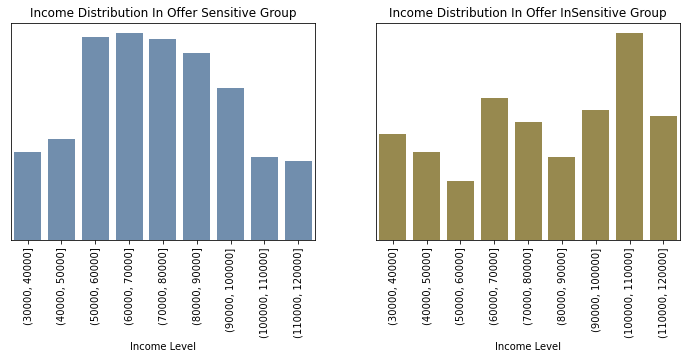

In [117]:
# compare income distribution in both groups

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

xlabel = offer_sensitive.income_level.unique().sort_values()

sns.countplot(ax=ax[0],data=offer_sensitive, x='income_level',color='#4172A6', alpha=0.8)

ax[0].set_title('Income Distribution In Offer Sensitive Group')
ax[0].set_xlabel('Income Level')
ax[0].get_yaxis().set_visible(False)
ax[0].set_xticklabels(xlabel,rotation=90)

sns.countplot(ax=ax[1],data=offer_insensitive, x='income_level',color='#8C7614', alpha=0.8)

ax[1].set_title('Income Distribution In Offer InSensitive Group')
ax[1].set_xlabel('Income Level')
ax[1].get_yaxis().set_visible(False)
ax[1].set_xticklabels(xlabel,rotation=90);



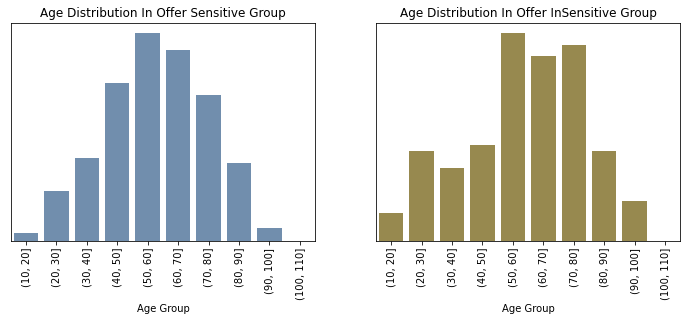

In [118]:
# compare age distribution in both groups

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

plt.xticks(rotation=70)

sns.countplot(ax=ax[0],data=offer_sensitive, x='age_group',color='#4172A6', alpha=0.8)

ax[0].set_title('Age Distribution In Offer Sensitive Group')
ax[0].set_xlabel('Age Group')
ax[0].get_yaxis().set_visible(False)
ax[0].tick_params(rotation=90)


sns.countplot(ax=ax[1],data=offer_insensitive, x='age_group',color='#8C7614', alpha=0.8)

ax[1].set_title('Age Distribution In Offer InSensitive Group')
ax[1].set_xlabel('Age Group')
ax[1].get_yaxis().set_visible(False)
ax[1].tick_params(rotation=90);

__So far, we have done the statistical analysis and discovered which which offer is winner and which group like which type of offer most, the summary will be presented at the end this notebook.__ 

__Next step we are going to build a predictive model by using Scikit-learn__

## Prepare data for ML Model

For this project we have multiclass to predict, three common machine learning algorithms will be used to build 3 models to predict what action a user could take when the user receives an offer:

* Logistic Regression
* Random Forest
* K-Nearest Neighor(KNN)

Since every machine learning alogrithms has some underlying assumptions, we first will prepare and check the data by following steps:

* encoding the column `channels`
* double checking missing value
* check distribution of single variable and relationship between two variables
* check label imbalance
* check outliers

Then, based on findings from above steps, we will create three datasets:

* First set for Random Forest which does not need data scaling, and works well if there is noise or outliers in the data, or class imbalanced.

* Second set for KNN which require data scaling and are sensitive to outliers

* Third set for for Logistic Regression which require data scaling and are sensitive to outliers. also the feature must be independent. 


In [119]:
offers_ml = offers_final.copy()
offers_ml.head(3)

,person,reward_target,channels,difficulty,duration,offer_type,offer_name,label,gender,age,income,age_group,income_level,year,days_being_member
0,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile]",5,7,bogo,bogo7+5,2,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443
1,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,-1,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443
2,78afa995795e4d85b5d9ceeca43f5fef,10,"[email, mobile, social]",10,7,bogo,bogo7+10,2,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443


In [120]:
# encodings to channels column

offers_ml['email'] = offers_ml['channels'].apply(lambda x: 1 if 'email' in x else 0) 
offers_ml['mobile'] = offers_ml['channels'].apply(lambda x: 1 if 'mobile' in x else 0) 
offers_ml['social'] = offers_ml['channels'].apply(lambda x: 1 if 'social' in x else 0)
offers_ml['web'] = offers_ml['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [121]:
offers_ml.head(3)

,person,reward_target,channels,difficulty,duration,offer_type,offer_name,label,gender,age,income,age_group,income_level,year,days_being_member,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile]",5,7,bogo,bogo7+5,2,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443,1,1,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,5,"[web, email, mobile, social]",5,5,bogo,bogo5+5,-1,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443,1,1,1,1
2,78afa995795e4d85b5d9ceeca43f5fef,10,"[email, mobile, social]",10,7,bogo,bogo7+10,2,F,75,100000.0,"(70, 80]","(90000, 100000]",2017,443,1,1,1,0


In [122]:
# drop columns which are no need for a ml model
offers_ml.drop(['person', 'channels', 'offer_name', 'age_group', 'income_level','year'], axis=1, inplace=True)


In [123]:
# check null value
offers_ml.isnull().sum()

reward_target        0
difficulty           0
duration             0
offer_type           0
label                0
gender               0
age                  0
income               0
days_being_member    0
email                0
mobile               0
social               0
web                  0
dtype: int64

In [124]:
offers_ml.head()

,reward_target,difficulty,duration,offer_type,label,gender,age,income,days_being_member,email,mobile,social,web
0,5,5,7,bogo,2,F,75,100000.0,443,1,1,0,1
1,5,5,5,bogo,-1,F,75,100000.0,443,1,1,1,1
2,10,10,7,bogo,2,F,75,100000.0,443,1,1,1,0
3,0,0,3,informational,1,F,75,100000.0,443,1,1,1,0
4,5,5,7,bogo,0,M,59,41000.0,1282,1,1,0,1


In [125]:
offers_ml.shape

(66945, 13)

#### Check distribution of single variable and relationship between two variables


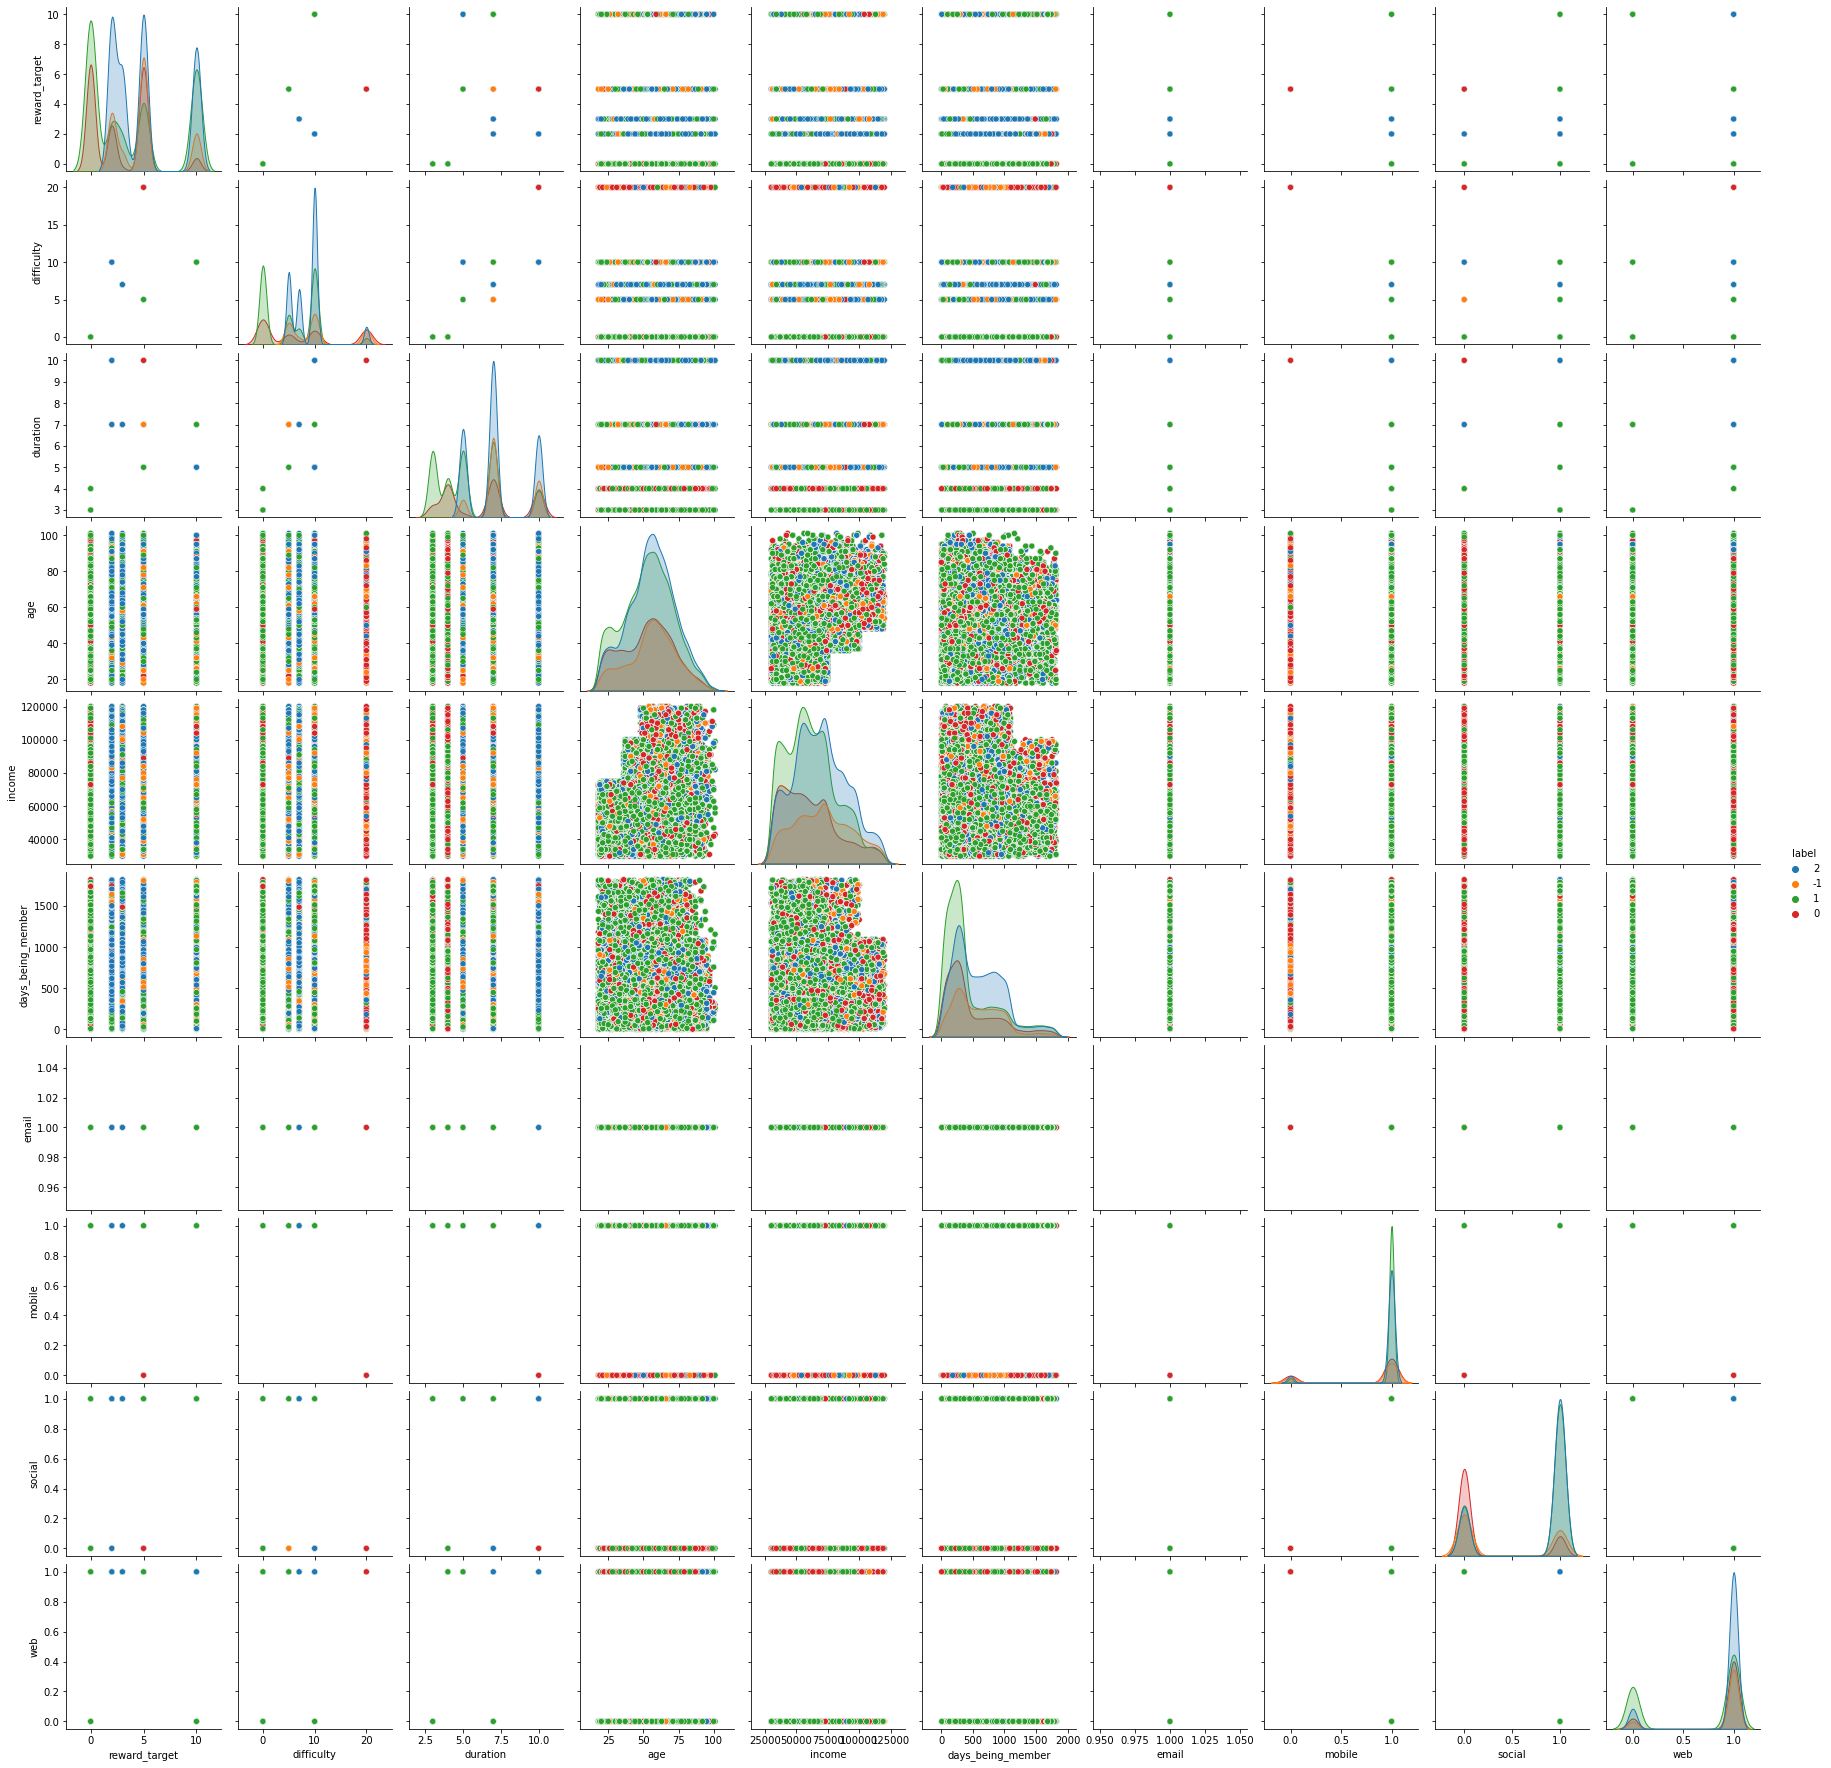

In [126]:
# See both distribution of single variables and relationships between two variables.
sns.pairplot(offers_ml, hue ='label');

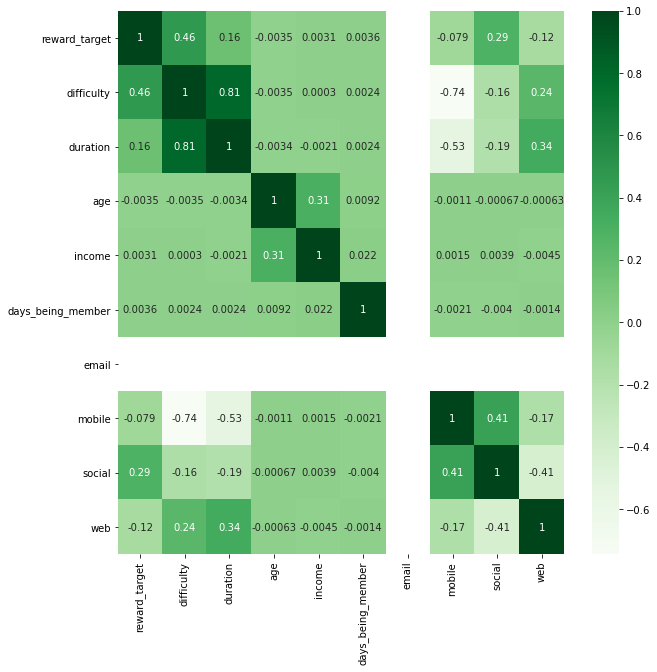

In [127]:
# Check the correlations between variables
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(offers_ml.corr(),annot=True, cmap="Greens");

We see `duration` and `difficulty` high correlated.

#### Label Imbalance 

An imbalance in the prediction label needs to be checked. This is important since it's a multi-class problem where two or more outcomes can be had. An imbalance in a response variable is bad since it means that some labels only occur a few times. This is an issue for machine learning algorithms if there are not enough data to train with which will give bad predictions. 

In our dataset, we observe that the counts of all the label are not equal, there is a large deviations between label 2 and 1 from label 0 and -1. SInce we dont have enough 0 and -1, the accuracy for those two label would be low.

In [128]:
offers_ml.label.value_counts()

2     22576
1     22456
0     12045
-1     9868
Name: label, dtype: int64

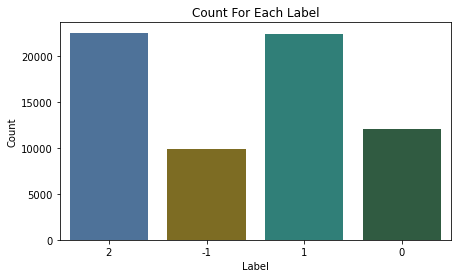

In [129]:
# visualize it ,'#67a9cf','#3690c0','#02818a','#016c59','#014636'
fig, ax = plt.subplots(figsize=(7,4))
colors2 = ['#4172A6','#8C7614','#238C83','#29623F']


sns.countplot(data=offers_ml, x='label', palette=sns.color_palette(colors2))
plt.title('Count For Each Label')
plt.xlabel('Label')
plt.ylabel('Count');


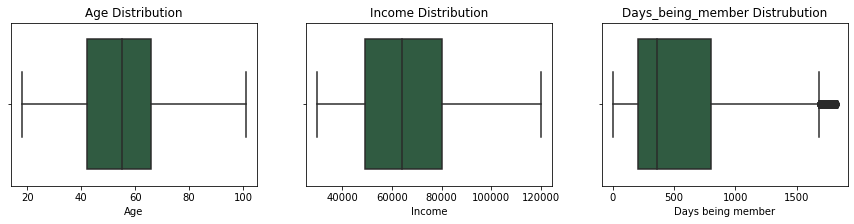

In [130]:
# check outliers of `age`,`income` and `days_being_member` by using box plot
fig, ax = plt.subplots(ncols=3, figsize=(15,3))
color = '#29623F'

sns.boxplot(ax=ax[0], data=offers_final, x='age', color=color)
ax[0].set_title('Age Distribution')
ax[0].set_xlabel('Age')

sns.boxplot(ax=ax[1], data=offers_ml, x='income', color=color)
ax[1].set_title('Income Distribution')
ax[1].set_xlabel('Income')


sns.boxplot(ax=ax[2], data=offers_ml, x='days_being_member', color=color)
ax[2].set_title('Days_being_member Distrubution')
ax[2].set_xlabel('Days being member');


We see there are outliers in `days_being_mmeber`. 

#### Create dataset for Random Forest

In [131]:
# get dummies for catergorical variables, split data into train and test set on ratio 70/30

X = pd.get_dummies(offers_ml.drop('label',axis=1),drop_first=True)
y = offers_ml['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

 #### Create dataset for KNN
 
 * Remove the outliers
 * Split the data and get dummies
 * Scale the data

In [132]:
# remove the outliers in `days_being_member` by using 1.5xIQR

Q1 = np.quantile(offers_final['days_being_member'],0.25)
Q3 = np.quantile(offers_final['days_being_member'],0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5*IQR

offers_ml2 = offers_ml[offers_ml['days_being_member'] <= upper_limit]

In [133]:
# see how many rows has been removed
offers_ml2.shape

(65826, 13)

In [134]:
# check the label imbalance again
offers_ml2.label.value_counts()

2     22192
1     22074
0     11819
-1     9741
Name: label, dtype: int64

In [135]:
# get dummies for catergorical variables, split data into train and test set on ratio 70/30

X2 = pd.get_dummies(offers_ml2.drop('label',axis=1),drop_first=True)
y2 = offers_ml2['label']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=101)

In [136]:
# Use standard scaler to scale the X2_train and X2_test for machine learning model 
scaler = StandardScaler()

scaled_X2_train = scaler.fit_transform(X2_train)
scaled_X2_test = scaler.transform(X2_test)

 #### Create dataset for Logistic Regression
 
 * Remove the outliers (did in previous step)
 * Split the data and get dummies and meantime drop `difficulty` which high correlated with `duration`
 * Scale the data

In [137]:
# drop `difficulty`
# get dummies for catergorical variables, split data into train and test set on ratio 70/30

X3 = pd.get_dummies(offers_ml2.drop(['difficulty','label'],axis=1),drop_first=True)
y3 = offers_ml2['label']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=101)

In [138]:
# Use standard scaler to scale the X23_train and X3_test for machine learning model 
scaler = StandardScaler()

scaled_X3_train = scaler.fit_transform(X3_train)
scaled_X3_test = scaler.transform(X3_test)

## ML Model building

As mentioned in previouse steps, we will build model with following three common machine learning algorithms:

* Logistic Regression: a fast, easy classification method,  
* Random Forest Classification: 
* K Nearest Neighbor Classification

Each of model was trained on a training dataset and evaluated on a testing dataset to avoid data leaking and to see how the models would perform on unseen data. Then we compare the models by checking following metrics. 

![](https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png)

Here is a quick description of the metrics:

- **Accuracy:** is the correct values divided by total values
- **Precision:** is the True Positives divided by the sum of True Positives and False Negatives. So precision is the values of the true positives divided by the actual positive values.
- **Recall:** is the True Positives divided by the sum of True Positives and False Positives. So recall is the values of the true positives divided by the positive guesses.
- **F1-score:** is a blended score of precision and recall which balances both values.
- **Macro Avg:** is the unweighted mean value of precision and recall. 
- **Weighted Avg:** is the weighted mean value of precision and recall by the support values for each class.
- **Support:** is the number of observations in class to predict. 

Since we have a high class imbalance, we will not only check the accuracy rate, but also the F1 score because a high F1 score considers both precision and recall. 

### 1: Logistic Regression

* __Strengths__: good accuracy on small amount of data,easy tointerpret (we get feature importance), easy to implement, efficient to train (doesn’t need high compute power), can do multi-class.


* __Weaknesses__: tend to overfit on high dimensions (use regularization), can’t do non-linear classification (or complex relationship), not good with multicollinearity, sensitive to outliers, requires linear relationship between log odds and target variable.


* __Hyperparameters__: in this project, we chose to use are: `solver = 'saga'` which is the algorithm to use in the optimization problem; `multi_class = ‘ovr’` (one-vs-rest schema), `class_weight = ‘balanced’` to auto adjust the weight of classes. We also use __GridSearch__ for best hyper-parameters: inverse of regularization strength `C` and `penalty` type.

In [139]:
# solver: Algorithm to use in the optimization problem. Default is ‘lbfgs’.
# The training algorithm uses the one-vs-rest (OvR) scheme
log_model = LogisticRegression(solver='saga',multi_class='ovr',class_weight='balanced')

In [140]:
log_model.fit(scaled_X3_train,y3_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', solver='saga')

In [141]:
y3_pred = log_model.predict(scaled_X3_test)

In [142]:
accuracy_score(y3_test,y3_pred)

0.5475491188981163

In [143]:
confusion_matrix(y3_test,y3_pred)

array([[1245,  536,  224,  900],
       [ 709, 2171,  491,  181],
       [ 401, 1228, 3245, 1701],
       [1253,  419,  892, 4152]])

In [144]:
print(classification_report(y3_test,y3_pred))

              precision    recall  f1-score   support

          -1       0.35      0.43      0.38      2905
           0       0.50      0.61      0.55      3552
           1       0.67      0.49      0.57      6575
           2       0.60      0.62      0.61      6716

    accuracy                           0.55     19748
   macro avg       0.53      0.54      0.53     19748
weighted avg       0.57      0.55      0.55     19748



#### GridSearch for Best Hyper-Parameters

Main parameter choices are regularization penalty choice and regularization C value.

In [145]:
# Penalty Type
penalty = ['l1', 'l2']

# Use logarithmically spaced C values
C = np.logspace(0, 4, 10)

In [146]:
grid_lr = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})

In [147]:
grid_lr.fit(scaled_X3_train,y3_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='ovr', solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [148]:
grid_lr.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [149]:
y3_pred = grid_lr.predict(scaled_X3_test)

In [150]:
accuracy_score(y3_test,y3_pred)

0.5475491188981163

In [151]:
confusion_matrix(y3_test,y3_pred)

array([[1245,  536,  223,  901],
       [ 709, 2171,  491,  181],
       [ 401, 1229, 3244, 1701],
       [1252,  420,  891, 4153]])

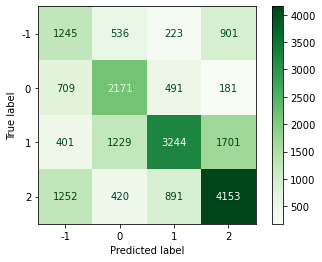

In [152]:
plot_confusion_matrix(grid_lr,scaled_X3_test,y3_test, cmap = "Greens")

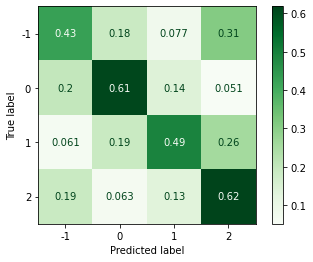

In [153]:
# Scaled so highest value=1
plot_confusion_matrix(grid_lr,scaled_X3_test,y3_test, normalize="true", cmap = "Greens")

In [154]:
print(classification_report(y3_test,y3_pred))

              precision    recall  f1-score   support

          -1       0.35      0.43      0.38      2905
           0       0.50      0.61      0.55      3552
           1       0.67      0.49      0.57      6575
           2       0.60      0.62      0.61      6716

    accuracy                           0.55     19748
   macro avg       0.53      0.54      0.53     19748
weighted avg       0.57      0.55      0.55     19748



### 2. Random Forest Classification

* __Strengths__: high accuracy, doesn’t need pruning, no overfitting, low bias with quite low/moderate variance (because of bootstrapping), can do both classification and regression, can do numerical and categorical, can classify non-linear data, data doesn’t need to be normalised nor scaled, not affected by missing values, not affected by outliers, performs well with unbalanced data (the nature of data distribution does not matter), can be parallelised (can use multiple CPUs in parallel), good with high dimensionality.

* __Weaknesses__: long training time, requires large memory, non interpretable (because there are hundreds of trees).

* __Hyperparameters__: In this project, instead of taking default of number of trees 100, we firstly use elbow method to find resonable number of tree __n_estimators__. Then will do GridSearch for Best Hyper-Parameters, the parameters we will try adjusting are:

   * `n_estimators`: number of trees in the forest. With large number of trees comes high accuracy, but high computational complexity.
   * `max_depth`: max number of levels in each decision tree
   * `max_features`: max number of features considered for splitting a node.
   * `bootstrap`:method for sampling data points (with or without replacement)
   * `oob_score`: Whether to use out-of-bag samples to estimate the generalization accuracy (# Note, oob_score only makes sense when bootstrap=True!)
   * `min_samples_leaf`: min number of data points allowed in a leaf node


#### Choosing resonable number of trees with Elbow Method

In [155]:
test_error = []

for n in range(1,40):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='auto')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))

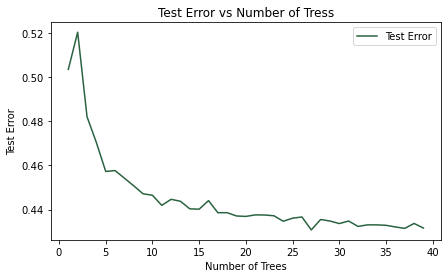

In [156]:
fig, ax = plt.subplots(figsize=(7,4))

plt.plot(range(1,40),test_error,label='Test Error', color='#29623F')
plt.xlabel("Number of Trees")
plt.ylabel("Test Error")
plt.title("Test Error vs Number of Tress")
plt.legend();

We can see after number 27, the test error starts keep similar. So we decide to use 27 as `n_estimators`

In [184]:
rfc27 = RandomForestClassifier(n_estimators=27,max_features='auto',random_state=101)

In [185]:
rfc27.fit(X_train,y_train)

RandomForestClassifier(n_estimators=27, random_state=101)

In [186]:
y_pred = rfc27.predict(X_test)

In [187]:
confusion_matrix(y_test,y_pred)

array([[ 913,  501,  385, 1191],
       [ 451, 1793,  974,  386],
       [ 261,  794, 4250, 1338],
       [ 809,  336, 1302, 4400]])

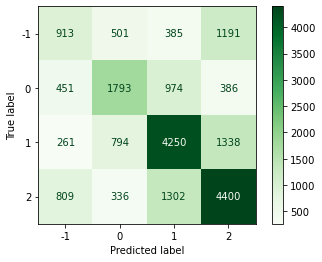

In [188]:
plot_confusion_matrix(rfc27,X_test,y_test, cmap = "Greens");

In [189]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.38      0.31      0.34      2990
           0       0.52      0.50      0.51      3604
           1       0.61      0.64      0.63      6643
           2       0.60      0.64      0.62      6847

    accuracy                           0.57     20084
   macro avg       0.53      0.52      0.52     20084
weighted avg       0.56      0.57      0.56     20084



#### Feature Importance

In [216]:
rfc27.feature_importances_

array([0.03378806, 0.0309578 , 0.03594652, 0.22287065, 0.23272838,
       0.3275907 , 0.        , 0.00957671, 0.04931515, 0.0107583 ,
       0.0073024 , 0.02156222, 0.01495347, 0.00264963])

In [217]:
imp_feats = pd.DataFrame(data=rfc27.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")

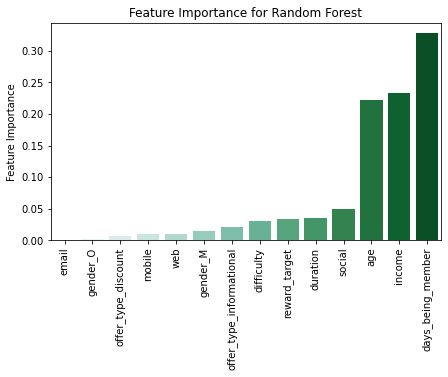

In [218]:
plt.figure(figsize=(7,4))

sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance', palette="BuGn")
plt.xticks(rotation=90)
plt.title("Feature Importance for Random Forest");

Above feature importance tells us `days_being_member`, `income`, `age` and `social` are the top 4 important features relate to a user's reaction to an offer.

#### GridSearch for Best Hyper-Parameters

We try to adjust following parameters: `bootstrap`, `oob_score`, `max_depth`, `max_features`, `min_samples_leaf`, `n_estimators`. 
            

In [167]:
# this param_grid is too heavy to run, so will set to parameters bit lighter

# Create the parameter grid
param_grid = {
    'bootstrap': [True, False],
    'oob_score': [True,False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_rfc = GridSearchCV(rfc, param_grid)

In [175]:
# Create the parameter grid

param_grid = {
    'bootstrap': [True, False],
    'oob_score': [True,False],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_rfc = GridSearchCV(rfc, param_grid)


In [176]:
grid_rfc.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [100, 200, 300],
                         'oob_score': [True, False]})

In [177]:
grid_rfc.best_params_

{'bootstrap': True, 'n_estimators': 300, 'oob_score': False}

In [178]:
y_preds = grid_rfc.predict(X_test)

In [179]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

          -1       0.38      0.29      0.33      2990
           0       0.53      0.51      0.52      3604
           1       0.62      0.64      0.63      6643
           2       0.61      0.66      0.63      6847

    accuracy                           0.57     20084
   macro avg       0.53      0.52      0.53     20084
weighted avg       0.56      0.57      0.57     20084



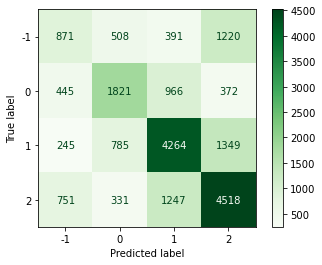

In [180]:
plot_confusion_matrix(grid_rfc, X_test, y_test, cmap = "Greens")

### 3. K Nearest Neighbor

* __Strengths__: simple to understand (intuitive), simple to implement (both binary and multi-class), handles non-linear data well, non parametric (no requirements on data distribution), respond quickly to data changes in real time implementation, can do both classification and regression.

* __Weaknesses__: long training time, doesn’t work well with high dimensional data, requires scaling, doesn’t work well with imbalanced data, sensitive to outliers and noise, affected by missing values.

* __Hyperparameters__: In this project, we start build model with default `n_neighbor`:5. Then we set up a machine learning pipeline, optimize and Tune the Pipeline to search best K value.

In [193]:
knn_model = KNeighborsClassifier()

In [194]:
knn_model.fit(scaled_X2_train,y2_train)

KNeighborsClassifier()

In [195]:
y2_preds = knn_model.predict(scaled_X2_test)

In [196]:
accuracy_score(y2_test,y2_preds)

0.5463338059550334

In [197]:
confusion_matrix(y2_test,y2_preds)

array([[1011,  435,  378, 1081],
       [ 596, 1760,  884,  312],
       [ 405,  761, 4158, 1251],
       [1056,  397, 1403, 3860]])

In [198]:
print(classification_report(y2_test,y2_preds))

              precision    recall  f1-score   support

          -1       0.33      0.35      0.34      2905
           0       0.52      0.50      0.51      3552
           1       0.61      0.63      0.62      6575
           2       0.59      0.57      0.58      6716

    accuracy                           0.55     19748
   macro avg       0.51      0.51      0.51     19748
weighted avg       0.55      0.55      0.55     19748



#### Full Cross Validation Grid Search for K Value

__*Creating a Pipeline to find K value*__

We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

In [199]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler',scaler),('knn',knn)]

In [200]:
pipe = Pipeline(operations)

In [201]:
k_values = list(range(1,40))
param_grid = {'knn__n_neighbors': k_values}

In [202]:
# we use f1 as scoring since we have imbalance labels
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='f1_micro')

In [203]:
full_cv_classifier.fit(X2_train,y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='f1_micro')

In [204]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=39))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=39),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 39,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [205]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [206]:
# how many total runs did we do?
len(k_values)

39

In [207]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.50227878, 0.46126129, 0.51862061, 0.53092584, 0.54533611,
       0.54865663, 0.55876984, 0.56000694, 0.56697328, 0.56994648,
       0.57166095, 0.57242061, 0.57363587, 0.5752418 , 0.57782442,
       0.57860575, 0.58042881, 0.58179604, 0.58173089, 0.58231688,
       0.58196966, 0.58281608, 0.58420498, 0.58307645, 0.58494289,
       0.58431352, 0.58533354, 0.58461737, 0.58513821, 0.58544205,
       0.58494291, 0.58659228, 0.58648371, 0.58733016, 0.5864404 ,
       0.58698296, 0.58639696, 0.58709143, 0.58821994])

We just saw that our  GridSearch recommends K=39, Let's now use the PipeLine again, but this time, no need to do a grid search, instead we will evaluate on our hold-out Test Set.

In [208]:
scaler = StandardScaler()
knn39 = KNeighborsClassifier(n_neighbors=39)
operations = [('scaler',scaler),('knn39',knn39)]

In [209]:
pipe_knn = Pipeline(operations)
pipe_knn.fit(X2_train,y2_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn39', KNeighborsClassifier(n_neighbors=39))])

In [210]:
pipe_preds = pipe_knn.predict(X_test)

In [211]:
print(classification_report(y_test,pipe_preds))

              precision    recall  f1-score   support

          -1       0.44      0.32      0.37      2990
           0       0.57      0.54      0.55      3604
           1       0.66      0.66      0.66      6643
           2       0.62      0.71      0.66      6847

    accuracy                           0.61     20084
   macro avg       0.57      0.56      0.56     20084
weighted avg       0.60      0.61      0.60     20084



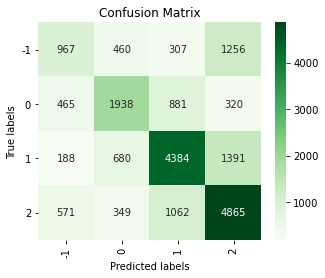

In [213]:
final_cm = confusion_matrix(y_test, pipe_preds)
knn_labels = knn39.classes_

plt.figure(figsize=(5,4))

ax= plt.subplot()
sns.heatmap(final_cm, annot=True, ax = ax, fmt="d", cmap = "Greens");

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.yaxis.set_tick_params(rotation=360)
ax.xaxis.set_tick_params(rotation=90)

ax.xaxis.set_ticklabels(knn_labels); 
ax.yaxis.set_ticklabels(knn_labels);

__pipe_knn with k=39 model looks better than other two. We did improve both accuracy and f1 score by tuning high parameters.__

## Conclusion

In this project, 30 days experiment involved 10 different offers and 306534 transcript records among 17000 users which registered as member between 2013 to 2018. There are three genders (M, F, O) and their age between 18 to 101 and income between 30k to 120k. 

By analyzing the data, we can answer our questions:

1. Which demographic groups are there and what the offers are that really excite them? In another word, what is the best offer, not just for the population as a whole but at an individual level?

  * The offer which led most view and most offer_completion is __discount10+10 (discount with duration 10 and difficulty 10)__.

  * __Discount10+10__ is also the offer which successfully influenced users and attracted users. Especially for the users who registered in Y2015 and Y2016, age between 30 to 70 and income between 40k to 100k.

  * Following discount10+10, __discount7+7__ is also one of the most popular offers.

  * Offer type __informaational__ led no any offer_completed, so suggest to remove it.


2. Which demographic groups will complete an offer even if they don't open an offer?

Users who have high income (over 100k) most likely not care if there is an offer or not, they just buy whenever they need. They are also the groud who completed most __discount10+20__. From business perspective, the better way is not send them any offer.

3. Can we build a machine learning model to predict which action a customer may take?

In this project, we built and tested two kinds of predict model by using machine learning (Random Forest Classification and K nearest neighbor) to predict four kinds reaction a customer might take:

  * Label 0: customer will not check an offer after received
  * label 1: customer will open the offer but not complete it
  * label 2: customer will complete the offer after view it
  * label -1: customer will complete without view it.
  
By tuning the parameters and evaluating the model, KNN model is better than others. Although it’s not good enough as a multi classifier predictive model, there is some space we could do to improve the model in future, such as counting in the transaction record, increasing demographic features of each user, and trying to scale data with other types of scalers, etc.